# Trabajo Final Análisis de Series de Tiempo I

## Sección 1: Procesamiento de los Datos

**Alumnos**: Trinidad Monreal, Jorge Ceferino Valdez y Jorge Blajevitch

### 1. a) Limpieza y Preparación de los Datos

#### 📥 Descripción general del dataset

Este trabajo analiza la evolución de la **capacidad nuclear instalada en Estados Unidos**, utilizando un conjunto de datos con registros diarios desde el año **2007** hasta **abril de 2021**.

##### Fuente de los datos
El dataset fue descargado de [Kaggle](https://www.kaggle.com/datasets/gagado/nuclear-capacity/data), pero no incluye referencias explícitas a su origen. No obstante, por su contenido y formato, se infiere que los datos provienen de la U.S. Energy Information Administration (EIA), particularmente de su sección dedicada a energía nuclear.

##### Columnas del dataset

- `Unnamed: 0`: representa la fecha de cada observación. El formato original es una cadena con información del año, mes, día y hora (por ejemplo, '2007 0101 01'). 
- `U.S. nuclear capacity, daily (Megawatts)`: indica la capacidad nuclear total instalada y operativa ese día, expresada en megavatios eléctricos (MW).

##### Periodicidad de los datos

Los datos están registrados **diariamente**, lo que permite analizar variaciones a corto y largo plazo, detectar patrones estacionales y aplicar distintos modelos de series de tiempo con granularidad alta.

El período cubierto por la serie va desde el **1 de enero de 2007** hasta el **21 de abril de 2021**, abarcando más de 14 años de observaciones diarias.

#### 🔍 Revisión estructural, formateo temporal y tratamiento de valores faltantes

Se comienza inspeccionando la estructura general del dataset utilizando los métodos `head()`, `info()` y `describe()`. Esto permite observar el tipo de datos, la cantidad de registros, la presencia de nulos y las estadísticas básicas de la variable principal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import scipy.stats as stats
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

/home/tmonreal/Desktop/Time_Series_Analysis/tpfinal_ast/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/Nuclear_Capacity.csv')

In [3]:
df.head()

,Unnamed: 0,"U.S. nuclear capacity, daily (Megawatts)"
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5225 entries, 0 to 5224
Data columns (total 2 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                5225 non-null   object 
 1   U.S. nuclear capacity, daily (Megawatts)  5225 non-null   float64
dtypes: float64(1), object(1)
memory usage: 81.8+ KB


In [5]:
df.describe()

,"U.S. nuclear capacity, daily (Megawatts)"
count,5225.000000
mean,100610.960287
std,2825.445609
min,27239.600000
25%,99277.900000
50%,101001.400000
75%,101764.900000
max,104182.000000


No se detectan valores nulos en las columnas, pero se realiza un chequeo explícito para confirmar:

In [6]:
df.isnull().sum()

Unnamed: 0                                  0
U.S. nuclear capacity, daily (Megawatts)    0
dtype: int64

Se realizó una limpieza detallada de la columna de fecha y una validación de la integridad temporal del dataset:


En primer lugar, se extrajo de la columna original sólo la parte correspondiente al año y al día (`'YYYY MMDD'`), descartando la tercera parte (número de fila o repetición). Esta cadena se convirtió al tipo `datetime` y se ordenó cronológicamente.

In [7]:
# Extraer solo la parte de la fecha (ignorando el número de fila)
df['fecha_str'] = df.iloc[:, 0].str.split(' ').str[:2].str.join(' ')

# Convertir a datetime
df['fecha'] = pd.to_datetime(df['fecha_str'], format='%Y %m%d')

# Ordenar el dataframe cronológicamente
df = df.sort_values('fecha')

Se generó un rango de fechas diario desde la fecha mínima hasta la máxima del dataset, y se comparó con las fechas disponibles para detectar posibles registros faltantes.

In [8]:
# Crear un rango completo de fechas y detectar faltantes
fecha_min = df['fecha'].min()
fecha_max = df['fecha'].max()
rango_completo = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

print(f'Fecha de inicio: {fecha_min}')
print(f'Fecha de fin: {fecha_max}')
print(f'Cantidad de fechas esperadas: {len(rango_completo)}')

Fecha de inicio: 2007-01-01 00:00:00
Fecha de fin: 2021-04-21 00:00:00
Cantidad de fechas esperadas: 5225


Se verificó que no hayan fechas que deberían estar presentes pero no aparecen en el dataset original. Esto es útil para confirmar la continuidad de la serie. En este caso no fue necesario realizar ninguna imputación.

In [9]:
# Identificar fechas faltantes
fechas_disponibles = set(df['fecha'].dt.date)
fechas_faltantes = [fecha.date() for fecha in rango_completo if fecha.date() not in fechas_disponibles]
print(f"Se encontraron {len(fechas_faltantes)} fechas faltantes")
if fechas_faltantes:
    print("Primeras 10 fechas faltantes:", fechas_faltantes[:10])

Se encontraron 0 fechas faltantes


Se reorganizaron las columnas para ubicar primero la fecha y luego la variable de interés. También, se renombró la columna larga por `'Capacidad'` para facilitar su uso posterior y se estableció la columna de fecha como índice.


In [10]:
# Reordenar y renombrar columnas
df = df[['fecha', 'U.S. nuclear capacity, daily (Megawatts)']]
df = df.rename(columns={'U.S. nuclear capacity, daily (Megawatts)': 'Capacidad'})

In [11]:
# Definir la fecha como índice
df.set_index('fecha', inplace=True)

In [12]:
df.head(5)

,Capacidad
fecha,
2007-01-01,101764.9
2007-01-02,101764.9
2007-01-03,101764.9
2007-01-04,101764.9
2007-01-05,101764.9


#### 📈 Visualización inicial de la serie temporal

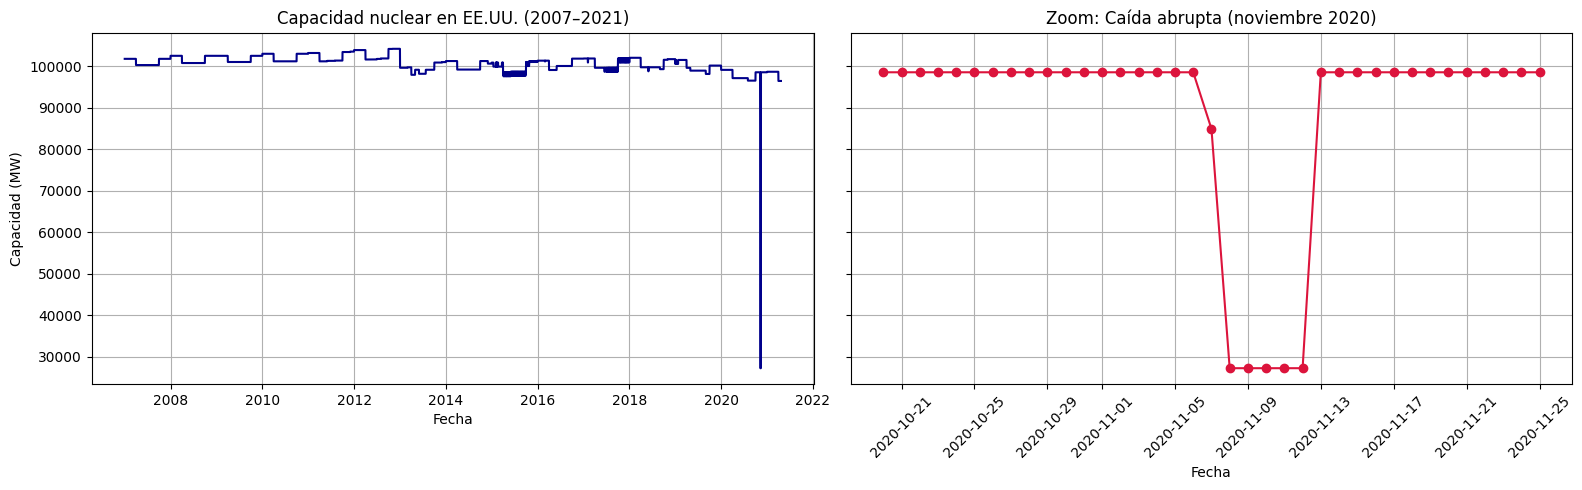

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)

axes[0].plot(df.index, df['Capacidad'], color='darkblue')
axes[0].set_title('Capacidad nuclear en EE.UU. (2007–2021)')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Capacidad (MW)')
axes[0].grid(True)

df_zoom = df[(df.index >= '2020-10-20') & (df.index <= '2020-11-25')]
axes[1].plot(df_zoom.index, df_zoom['Capacidad'], color='crimson', marker='o')
axes[1].set_title('Zoom: Caída abrupta (noviembre 2020)')
axes[1].set_xlabel('Fecha')
axes[1].grid(True)

for label in axes[1].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

> Durante el mes de noviembre de 2020 se observa una caída abrupta y temporal en la capacidad nuclear diaria reportada, pasando de ~98.000 MW a ~27.000 MW entre los días 8 y 12. Esta caída representa más del 70% de la capacidad instalada, y se recupera completamente el 13 de noviembre.
>
> El comportamiento observado sugiere un evento atípico, posiblemente debido a un error en la carga de datos, mantenimiento masivo o prueba de sistemas. Dada su forma abrupta y la repetición exacta de valores durante varios días, es altamente probable que se trate de una anomalía en la fuente de datos más que de un reflejo del estado real del sistema energético.
>
> Este evento será considerado como *outlier* y se analizará si conviene eliminarlo o suavizarlo en la fase de modelado.

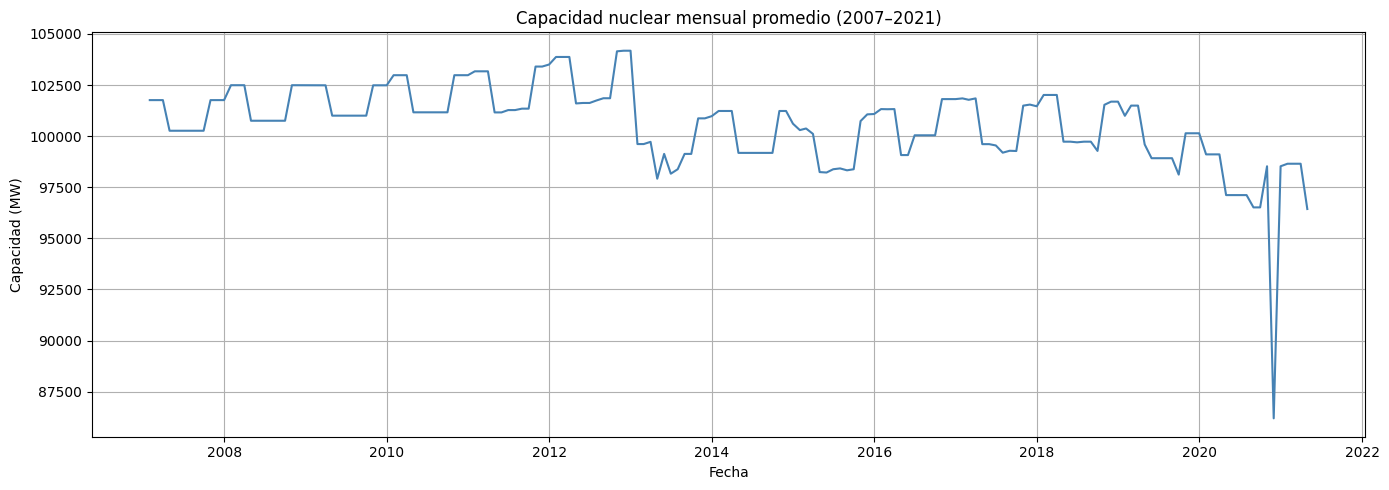

In [14]:
df_resample = df['Capacidad'].resample('ME').mean() # Mensual

plt.figure(figsize=(14, 5))
plt.plot(df_resample, color='steelblue')
plt.title('Capacidad nuclear mensual promedio (2007–2021)')
plt.xlabel('Fecha')
plt.ylabel('Capacidad (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

> El gráfico mensual promedio muestra que la capacidad nuclear de EE.UU. se mantiene bastante estable a lo largo de los años, aunque se sigue observando la caída abrupta a finales de 2020 y recuperación inmediata, indicando un evento atípico o un error en los datos.

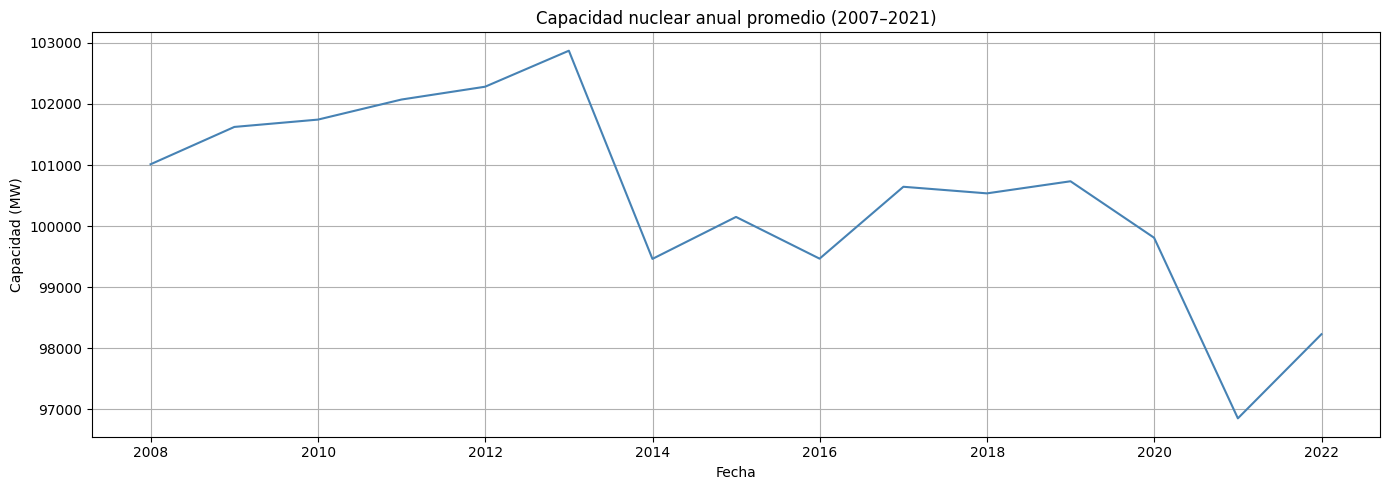

In [15]:
df_resample = df['Capacidad'].resample('YE').mean() # Anual

plt.figure(figsize=(14, 5))
plt.plot(df_resample, color='steelblue')
plt.title('Capacidad nuclear anual promedio (2007–2021)')
plt.xlabel('Fecha')
plt.ylabel('Capacidad (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

> El gráfico anual promedio muestra que la capacidad nuclear en EE.UU. se mantuvo prácticamente constante entre 2007 y 2019 (la fluctuación es baja), con una disminución más marcada en 2021, probablemente asociada a cierres de reactores o datos incompletos. Nuevamente, esta estabilidad a lo largo del tiempo sugiere un sistema nuclear consolidado con pocas expansiones o retiros estructurales.

<Figure size 1000x500 with 0 Axes>

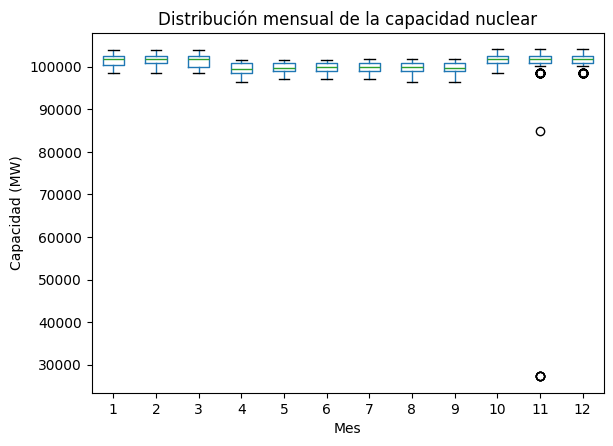

In [16]:
df['Mes'] = df.index.month
plt.figure(figsize=(10, 5))
df.boxplot(column='Capacidad', by='Mes', grid=False)
plt.title('Distribución mensual de la capacidad nuclear')
plt.suptitle('')
plt.xlabel('Mes')
plt.ylabel('Capacidad (MW)')
plt.show()


> El boxplot mensual revela que la capacidad es muy similar entre meses, pero existen outliers negativos muy marcados en noviembre y diciembre, en coincidencia con la caída antes mencionada.

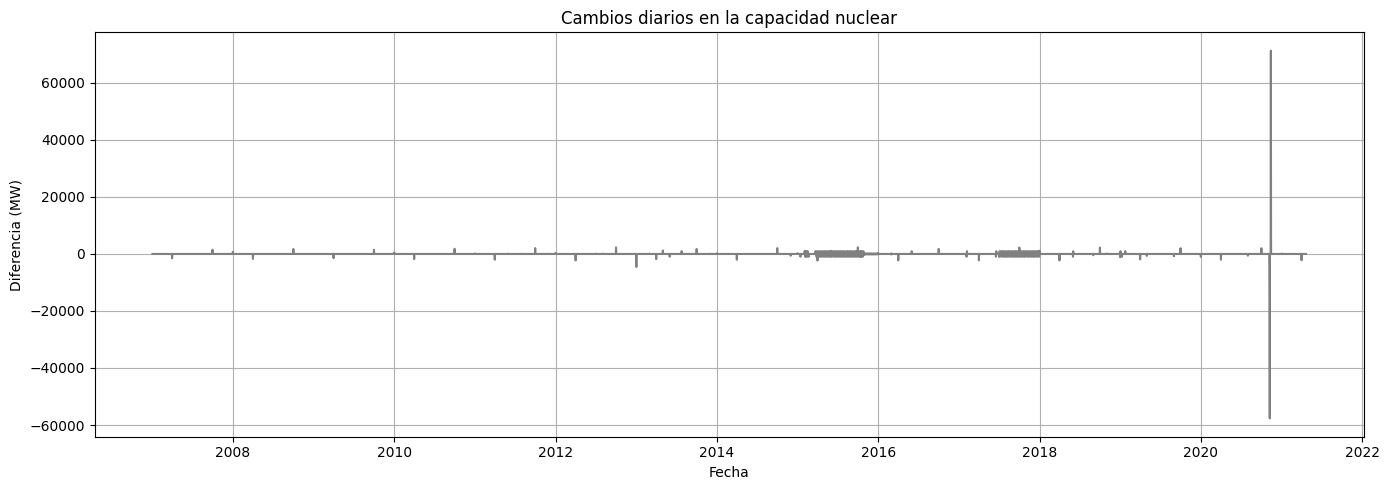

In [17]:
df['Cambio_diario'] = df['Capacidad'].diff()

plt.figure(figsize=(14, 5))
plt.plot(df['Cambio_diario'], color='gray')
plt.title('Cambios diarios en la capacidad nuclear')
plt.xlabel('Fecha')
plt.ylabel('Diferencia (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

> El gráfico de diferencias diarias evidencia que la variabilidad es generalmente baja, salvo por saltos extremadamente grandes en 2020, lo que refuerza la idea de un evento puntual o anomalía en ese período.

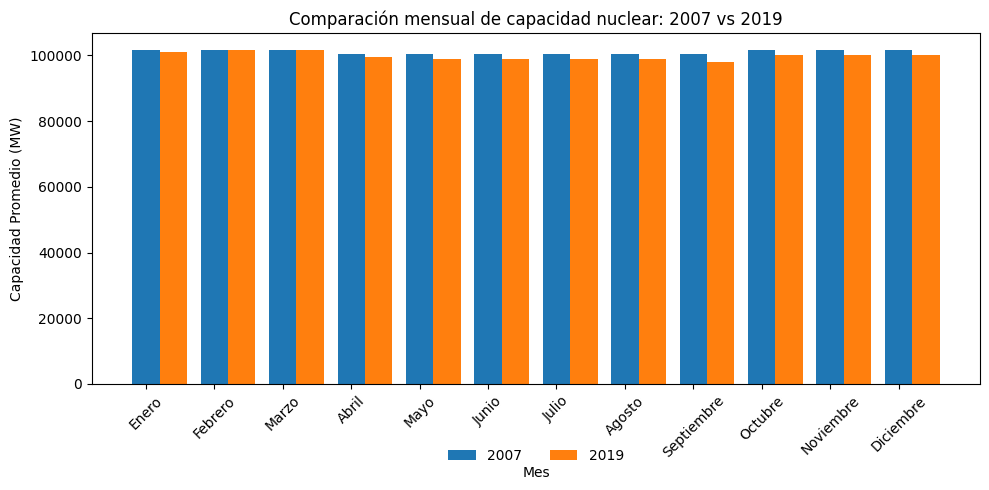

In [18]:
df_2007 = df[df.index.year == 2007]
df_2019 = df[df.index.year == 2019]

# Calcular promedios mensuales
prom_2007 = df_2007['Capacidad'].resample('ME').mean()
prom_2019 = df_2019['Capacidad'].resample('ME').mean()

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
         'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Crear gráfico de barras comparativo
plt.figure(figsize=(10, 5))
plt.bar(range(12), prom_2007.values, width=0.4, label='2007', align='edge', color='#1f77b4')
plt.bar([x + 0.4 for x in range(12)], prom_2019.values, width=0.4, label='2019', align='edge', color='#ff7f0e')

plt.xticks([x + 0.2 for x in range(12)], meses, rotation=45)
plt.xlabel('Mes')
plt.ylabel('Capacidad Promedio (MW)')
plt.title('Comparación mensual de capacidad nuclear: 2007 vs 2019')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

> El gráfico compara la capacidad mensual promedio de dos años representativos: 2007, primer año de la serie, y 2019, el último año completo antes de la pandemia.
Permite identificar cambios estructurales o estacionales en la operación del sistema nuclear, y observar si existe una variación sistemática en ciertos meses (por ejemplo, por mantenimientos programados). También sirve como línea base para luego contrastar con años pandémicos (como 2020).
>
> En la comparación se nota una leve disminución general en 2019 respecto a 2007, especialmente en los meses de abril a junio, lo que podría indicar un cambio en los patrones operativos o la baja de algunos reactores.

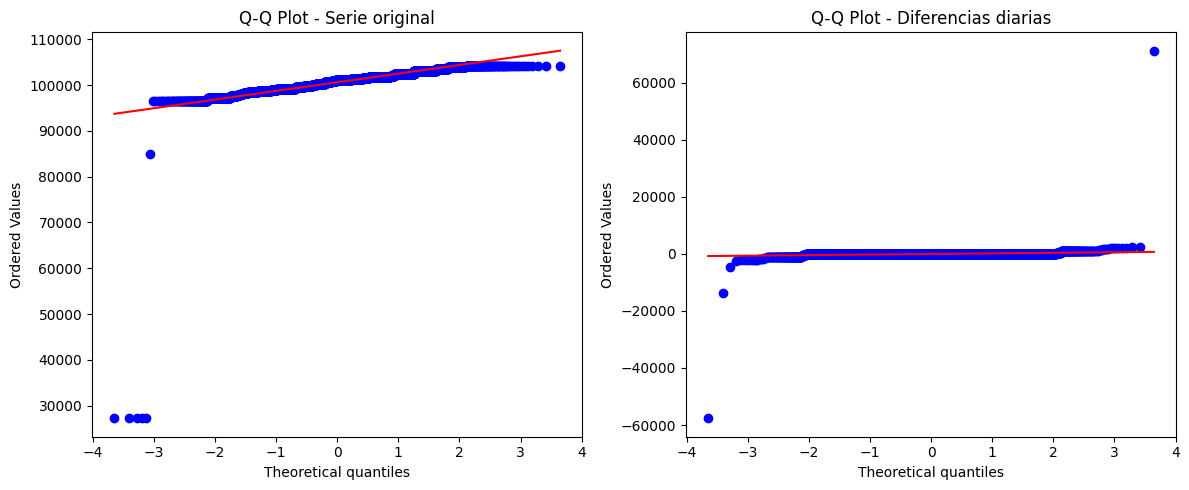

In [19]:
plt.figure(figsize=(12, 5))

# Q-Q plot de la serie original
plt.subplot(1, 2, 1)
stats.probplot(df['Capacidad'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Serie original")

# Q-Q plot de las diferencias
df_diff = df['Capacidad'].diff().dropna()
plt.subplot(1, 2, 2)
stats.probplot(df_diff, dist="norm", plot=plt)
plt.title("Q-Q Plot - Diferencias diarias")

plt.tight_layout()
plt.show()

> - Serie original (izquierda): muestra una desviación respecto a la línea recta en los extremos. Esto indica que la distribución de la capacidad nuclear no es normal y tiene colas pesadas, probablemente por la estructura de la serie (tendencia, eventos abruptos como el de 2020, etc.).
>
> - Diferencias diarias (derecha): el Q-Q plot se ajusta mucho mejor a la línea recta, lo que sugiere que los cambios diarios en la capacidad se aproximan a una distribución normal, aunque todavía hay cierta asimetría en los extremos.

#### Prueba de estacionariedad

##### Prueba de Dickey-Fuller aumentada (ADF)

Vamos a aplicar la prueba de Dickey-Fuller aumentada (ADF):

- Hipótesis nula ($H_0$): la serie NO es estacionaria.

- Hipótesis alternativa ($H_1$): la serie es estacionaria.

Si el p-valor ≤ 0.05, rechazamos $H_0 \rightarrow$ la serie es estacionaria. 

In [20]:
# Función para ejecutar y reportar la prueba de Dickey-Fuller aumentada (ADF)
def check_stationarity(series, name=""):
    result = sts.adfuller(series.dropna())
    print(f'Prueba ADF para {name}:')
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-valor: {result[1]:.4f}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] <= 0.01:
        conclusion = "Estacionaria al 1% (evidencia muy fuerte)"
    elif result[1] <= 0.05:
        conclusion = "Estacionaria al 5% (evidencia fuerte)"
    elif result[1] <= 0.10:
        conclusion = "Estacionaria al 10% (evidencia débil)"
    else:
        conclusion = "No estacionaria (> 10%)"
    print(f"Conclusión: {conclusion}")
    print("-" * 50)
    return result[1] <= 0.05

In [21]:
# Función para graficar la serie original y su transformación
def plot_series(original, transformed, title="Comparación de Series"):
    plt.figure(figsize=(12, 6))
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.title("Serie Original")
    plt.subplot(2,1,2)
    plt.plot(transformed, color='red')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Prueba ADF para Capacidad:
Estadístico ADF: -5.6329
p-valor: 0.0000
Valores críticos:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671
Conclusión: Estacionaria al 1% (evidencia muy fuerte)
--------------------------------------------------
Prueba ADF para Diferencia de Capacidad:
Estadístico ADF: -20.2899
p-valor: 0.0000
Valores críticos:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671
Conclusión: Estacionaria al 1% (evidencia muy fuerte)
--------------------------------------------------


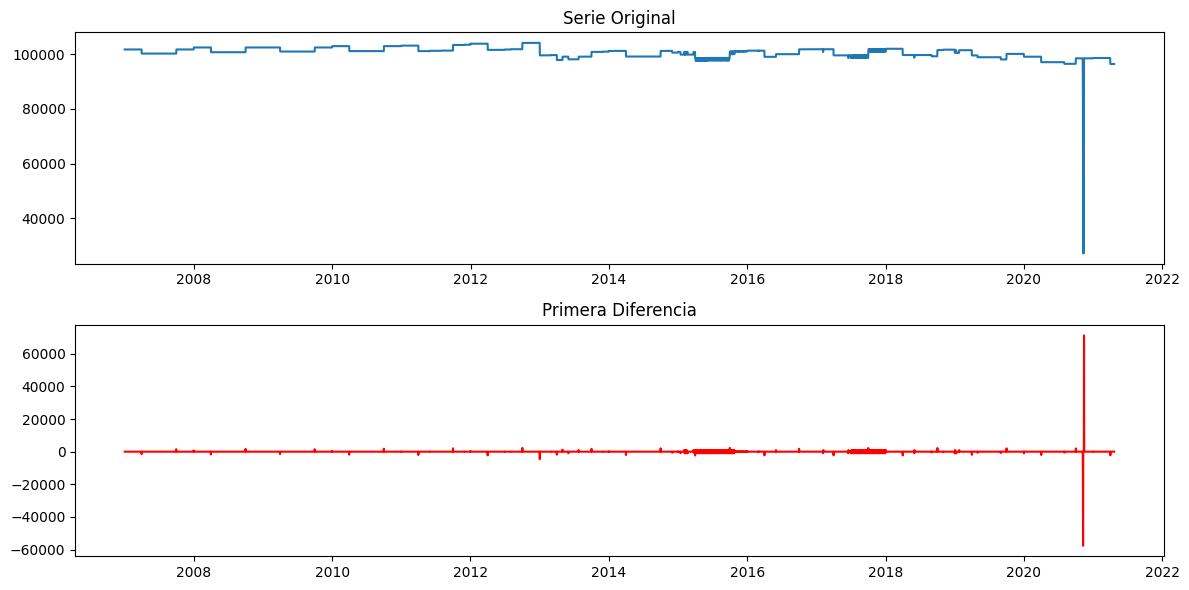

In [22]:
# Serie original
serie_original = df['Capacidad']
resultado_original = check_stationarity(serie_original, name="Capacidad")

# Serie diferenciada
serie_diff = serie_original.diff().dropna()
resultado_diff = check_stationarity(serie_diff, name="Diferencia de Capacidad")

# Visualización comparativa
plot_series(serie_original, serie_diff, title="Primera Diferencia")

Aunque el test ADF sugiere que la serie original es estacionaria, la inspección visual, la presencia de eventos atípicos y la baja variabilidad en la mayoría del período nos interesa evaluar los efectos de aplicar una primera diferencia. La serie diferenciada muestra estacionariedad clara, lo que podría validar el uso de modelos ARIMA con parámetro d=1.

Como criterio complementario, seguimos por graficar la media y varianza móviles.

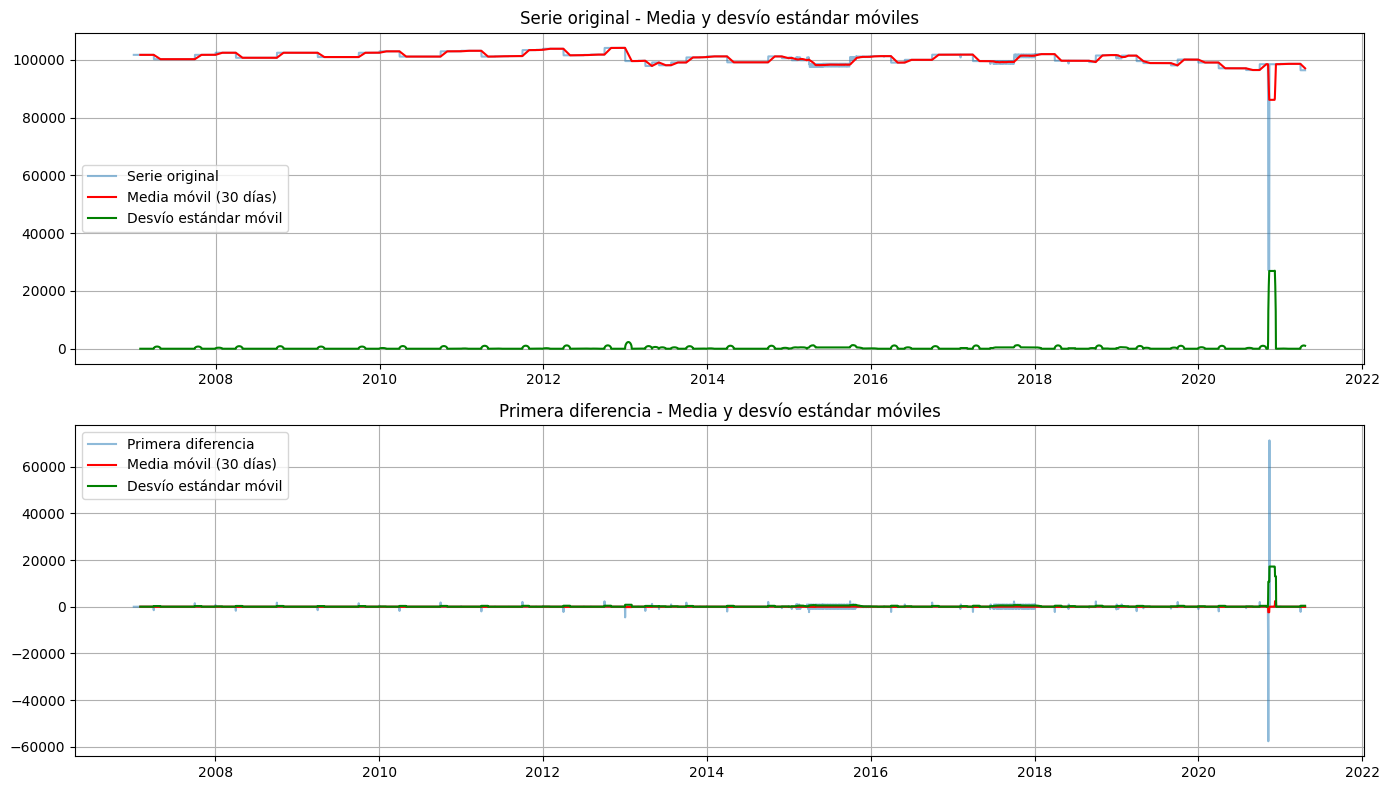

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
ventana = 30  # ventana suavizado 30 días

# Media y desvío estándar móviles de serie original
media_movil_orig = df['Capacidad'].rolling(window=ventana).mean()
std_movil_orig = df['Capacidad'].rolling(window=ventana).std()

# Media y desvío estándar móviles de diferencia
media_movil_diff = serie_diff.rolling(window=ventana).mean()
std_movil_diff = serie_diff.rolling(window=ventana).std()

# Original
axes[0].plot(df['Capacidad'], label='Serie original', alpha=0.5)
axes[0].plot(media_movil_orig, label='Media móvil (30 días)', color='red')
axes[0].plot(std_movil_orig, label='Desvío estándar móvil', color='green')
axes[0].set_title("Serie original - Media y desvío estándar móviles")
axes[0].legend()
axes[0].grid(True)

# Diferenciada
axes[1].plot(serie_diff, label='Primera diferencia', alpha=0.5)
axes[1].plot(media_movil_diff, label='Media móvil (30 días)', color='red')
axes[1].plot(std_movil_diff, label='Desvío estándar móvil', color='green')
axes[1].set_title("Primera diferencia - Media y desvío estándar móviles")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

En la serie original (gráfico superior), la <span style="color:red">media móvil</span> no se mantiene constante: hay tramos planos, pero también cambios bruscos (aun sin tener en cuenta el outlier de 2020). La varianza móvil también se ve afectada por eventos anómalos.

En la serie diferenciada (gráfico inferior), tanto la media como la varianza móviles son mucho más estables a lo largo del tiempo.

A continuación, se grafican las funciones ACF y PACF para estimar los órdenes adecuados de los componentes autorregresivos (AR) y de media móvil (MA), necesarios para modelar con ARIMA.

#### Gráficos ACF (Autocorrelation Function) y PACG (Partial Autocorrelation Function)

Las funciones ACF y PACF permiten analizar la dependencia temporal en una serie. La ACF mide la correlación entre observaciones separadas por distintos rezagos (lags), incluyendo la influencia indirecta de otros lags. En cambio, la PACF mide la correlación entre una observación y su rezago excluyendo las influencias intermedias, es decir, la correlación “pura” entre $X(t)$ y $X(t-k)$. Estas herramientas son fundamentales para elegir los órdenes adecuados de los componentes AR (autoregresivos) y MA (media móvil) en modelos ARIMA.

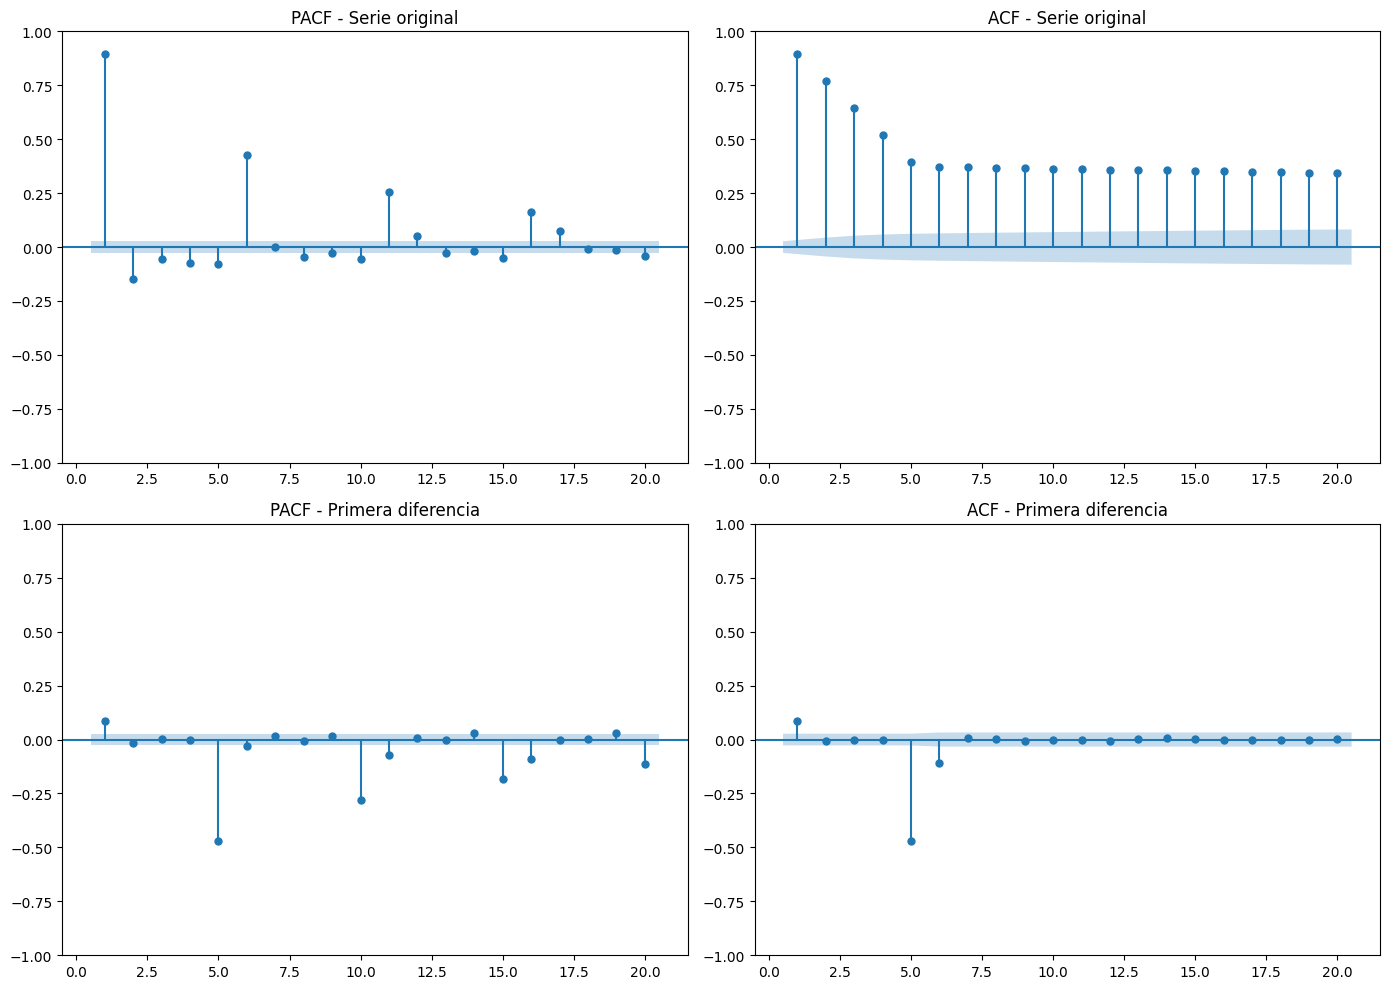

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# PACF serie original
sgt.plot_pacf(serie_original.dropna(), ax=axes[0, 0], zero=False, lags=20, method='ywm')
axes[0, 0].set_title("PACF - Serie original")

# ACF serie original
sgt.plot_acf(serie_original.dropna(), ax=axes[0, 1], zero=False, lags=20)
axes[0, 1].set_title("ACF - Serie original")

# PACF primera diferencia
sgt.plot_pacf(serie_diff, ax=axes[1, 0], zero=False, lags=20, method='ywm')
axes[1, 0].set_title("PACF - Primera diferencia")

# ACF primera diferencia
sgt.plot_acf(serie_diff, ax=axes[1, 1], zero=False, lags=20)
axes[1, 1].set_title("ACF - Primera diferencia")

plt.tight_layout()
plt.show()

**Serie original:**

- El PACF muestra un pico fuerte en el lag 1 y picos menores en lags 6 y 11.
- El ACF decae lentamente, lo que es típico de una serie con estructura autoregresiva (no MA).
- Ambos sugieren que un modelo AR(p) puede ser más apropiado que un MA puro.
- Modelos candidatos: (se deberián probar y comparar los siguientes modelos)
    * AR(1): Para comparar la estructura básica.
    * AR(6): Para incluir el segundo pico significativo.
    * AR(11): Para incluir todos los picos significativos.
    * ARMA(1,1): Aunque el ACF no muestra un patrón de decaimiento característico de un MA puro, incluir este modelo permite capturar posibles componentes residuales que un AR puro podría no modelar completamente. También puede ayudar a comparar ajustes y evaluar mejoras en los errores de predicción.

**Primera diferencia:**

- El PACF muestra un pico negativo fuerte en el lag 5 y valores relevantes en los lags 10 y 15, lo que sugiere una posible estructura periódica cada 5 unidades.
- El ACF presenta un valor positivo leve en el lag 1 y un pico negativo significativo en el lag 5, pero luego se estabiliza cerca de cero, sin decaimiento progresivo.
- Ambos indican que un modelo ARIMA con lags múltiples o un SARIMA con componente estacional s=5 podría capturar mejor la dinámica de la serie que un ARIMA simple.
- Modelos candidatos: (se deberián probar y comparar los siguientes modelos)
    * ARIMA(1,1,0): Para capturar una estructura autoregresiva básica con la primera diferencia.
    * ARIMA([5],1,0): Para incluir directamente el lag 5, que muestra un efecto fuerte y repetitivo.
    * ARIMA([5,10],1,0) o ARIMA([5,10,15],1,0): Para considerar explícitamente la posible periodicidad de 5 unidades detectada en el PACF.
    * ARIMA(0,1,1): Para testear si un modelo con solo componente MA podría ser suficiente, dada la forma del ACF.
    * ARIMA(1,1,1): Como modelo balanceado básico para comparar con otros, aunque los gráficos no lo sugieren fuertemente.
    * SARIMA(0,1,0)(1,0,0,5): Para modelar directamente la estacionalidad cada 5 pasos como un componente estructural estacional AR.
    * SARIMA(0,1,0)(0,0,1,5): Variante alternativa si se sospecha un componente estacional MA.
    * SARIMA(0,1,0)(1,0,1,5): Modelo mixto estacional simple para capturar ambas dinámicas con estacionalidad s=5.

#### Tratamiento de outliers

Antes de proceder con el modelado, se realiza un tratamiento puntual de los valores atípicos detectados en noviembre de 2020 mediante interpolación lineal, con el fin de evitar que afecten negativamente el ajuste de los modelos.

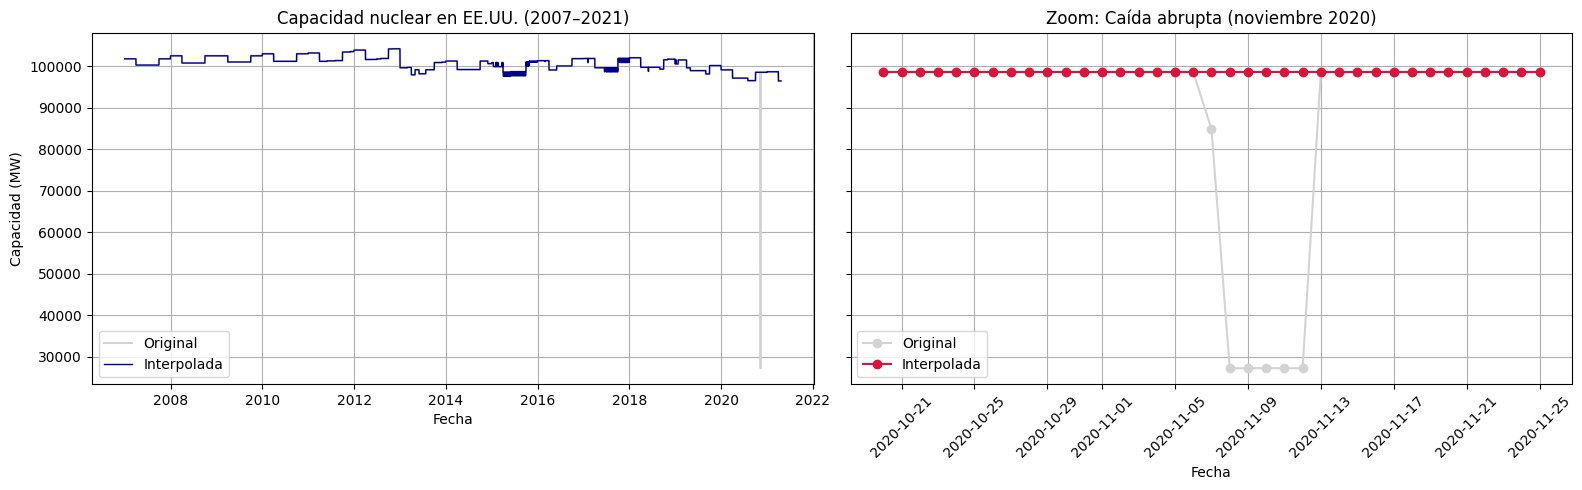

In [25]:
df_clean = df.copy()
outlier_dates = pd.date_range(start='2020-11-07', end='2020-11-12')
df_clean.loc[outlier_dates, 'Capacidad'] = np.nan
df_clean['Capacidad'] = df_clean['Capacidad'].interpolate()

# Zoom para noviembre
df_zoom = df_clean[(df_clean.index >= '2020-10-20') & (df_clean.index <= '2020-11-25')]

fig, axes = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)

# Gráfico general con comparación
axes[0].plot(df.index, df['Capacidad'], label='Original', color='lightgray', linewidth=1.5)
axes[0].plot(df_clean.index, df_clean['Capacidad'], label='Interpolada', color='darkblue', linewidth=1)
axes[0].set_title('Capacidad nuclear en EE.UU. (2007–2021)')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Capacidad (MW)')
axes[0].legend()
axes[0].grid(True)

# Gráfico con zoom
axes[1].plot(df_zoom.index, df.loc[df_zoom.index, 'Capacidad'], label='Original', color='lightgray', marker='o')
axes[1].plot(df_zoom.index, df_zoom['Capacidad'], label='Interpolada', color='crimson', marker='o')
axes[1].set_title('Zoom: Caída abrupta (noviembre 2020)')
axes[1].set_xlabel('Fecha')
axes[1].legend()
axes[1].grid(True)

for label in axes[1].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.show()

Con el objetivo de validar la robustez de los resultados, se repitieron las pruebas ADF, ACF y PACF sobre la serie limpia para comparar la estructura estadística sin la influencia de los valores atípicos en noviembre 2020:

##### Prueba de ADF

Prueba ADF para Capacidad:
Estadístico ADF: -5.6329
p-valor: 0.0000
Valores críticos:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671
Conclusión: Estacionaria al 1% (evidencia muy fuerte)
--------------------------------------------------
Prueba ADF para Diferencia de Capacidad:
Estadístico ADF: -13.6057
p-valor: 0.0000
Valores críticos:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671
Conclusión: Estacionaria al 1% (evidencia muy fuerte)
--------------------------------------------------


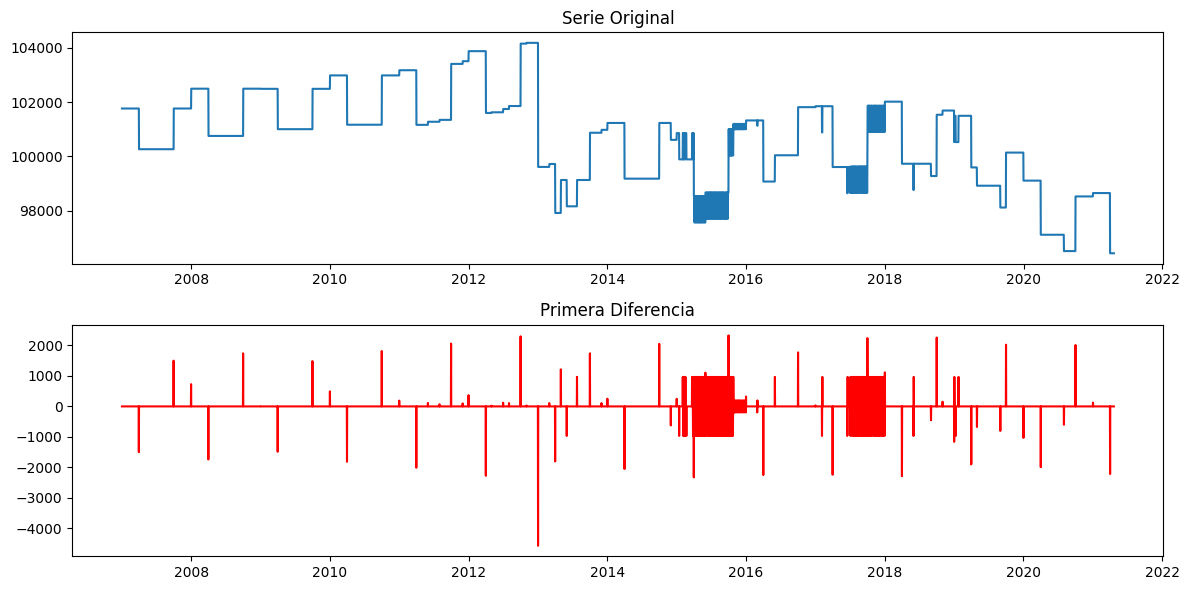

In [26]:
# Serie original
serie_original_limpia = df_clean['Capacidad']
resultado_original = check_stationarity(serie_original, name="Capacidad")

# Serie diferenciada
serie_diff_limpia = serie_original_limpia.diff().dropna()
resultado_diff = check_stationarity(serie_diff_limpia, name="Diferencia de Capacidad")

# Visualización comparativa
plot_series(serie_original_limpia, serie_diff_limpia, title="Primera Diferencia")

La serie original limpia (sin outliers) resulta claramente estacionaria según el test ADF, con un estadístico de -5.63 y un p-valor < 0.01. Esto implica que no es necesario aplicar una diferencia para modelarla con un ARMA(p,q), aunque se puede hacer por comparación. 

#### Gráficos ACF (Autocorrelation Function) y PACG (Partial Autocorrelation Function)

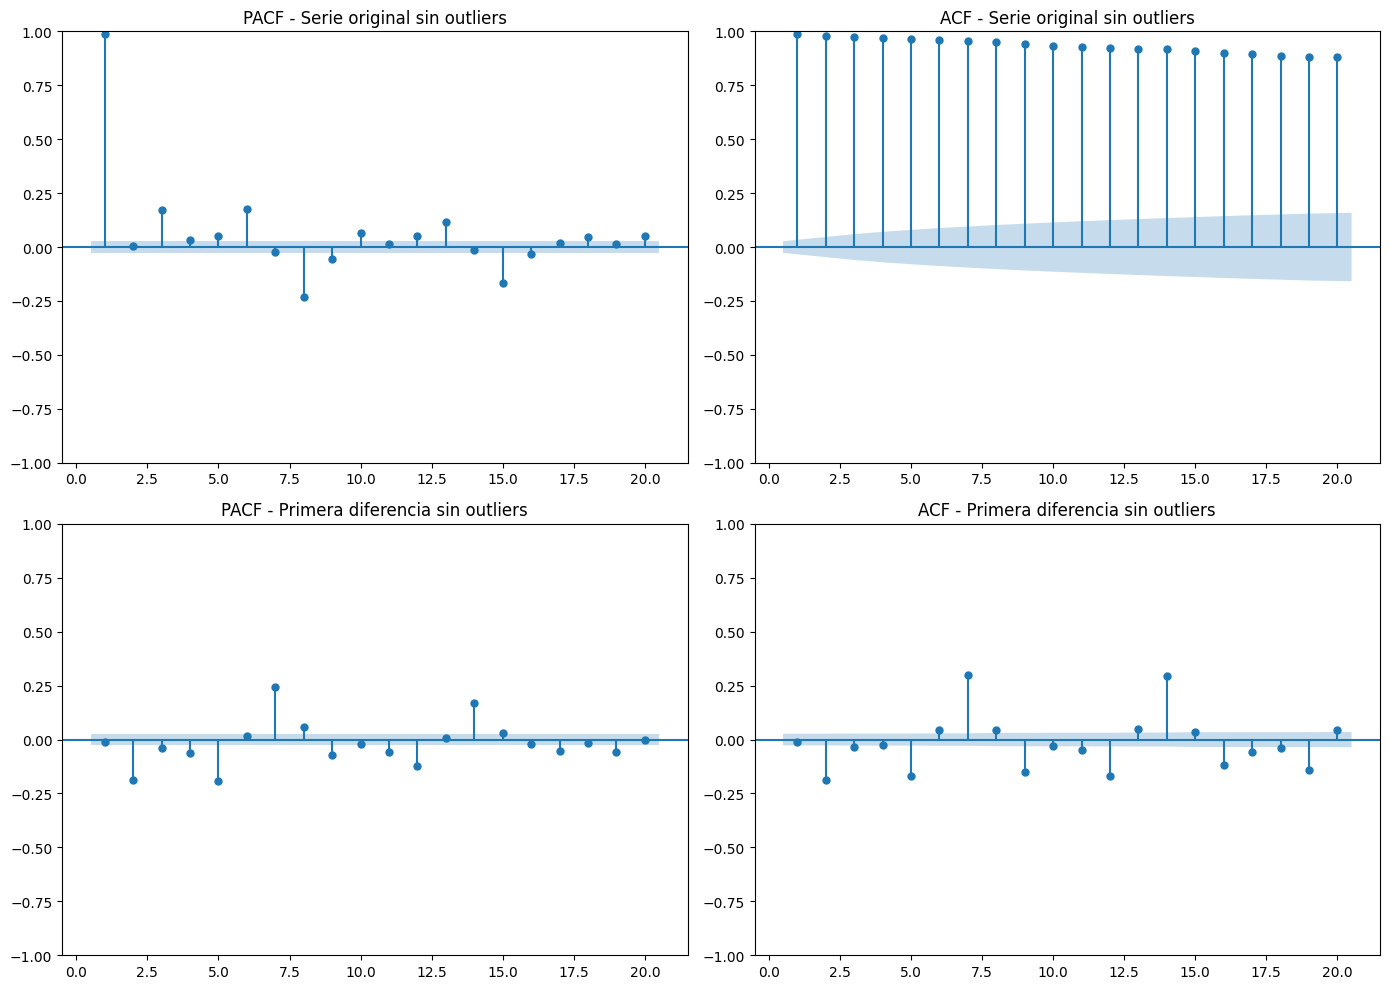

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# PACF serie original
sgt.plot_pacf(serie_original_limpia.dropna(), ax=axes[0, 0], zero=False, lags=20, method='ywm')
axes[0, 0].set_title("PACF - Serie original sin outliers")

# ACF serie original
sgt.plot_acf(serie_original_limpia.dropna(), ax=axes[0, 1], zero=False, lags=20)
axes[0, 1].set_title("ACF - Serie original sin outliers")

# PACF primera diferencia
sgt.plot_pacf(serie_diff_limpia, ax=axes[1, 0], zero=False, lags=20, method='ywm')
axes[1, 0].set_title("PACF - Primera diferencia sin outliers")

# ACF primera diferencia
sgt.plot_acf(serie_diff_limpia, ax=axes[1, 1], zero=False, lags=20)
axes[1, 1].set_title("ACF - Primera diferencia sin outliers")

plt.tight_layout()
plt.show()

**Serie original (sin outliers)**:
- El PACF sigue mostrando un pico fuerte en lag 1, pero los picos en lags 6 y 11 son mucho menos relevantes. Esto sugiere que aquellos valores eran probablemente inducidos por los outliers de noviembre de 2020, y no reflejaban una dependencia real.
- El ACF mantiene un decaimiento lento, lo cual sigue siendo característico de un proceso autoregresivo, aunque ahora se ve muy limpio y menos errático.
- La serie original sin outliers mantiene una estructura compatible con un modelo AR, pero con menos ruido. Se justifican como modelos candidatos:
    * AR(1): por el pico fuerte en lag 1. 
    * ARIMA(1,1): para capturar potenciales componentes de ruido no explicados por AR(1).

**Primera diferencia (sin outliers)**:
- El PACF ya no muestra un pico claro en lag 5, y los valores en lags 10 y 15 son más suaves y cercanos a cero. Esto indica que la aparente estructura periódica de múltiplos de 5 se podría deber en gran parte a los outliers.
- El ACF no muestra ningún patrón fuerte: solo pequeños picos aislados (por ejemplo, en lag 7 o 13), pero sin estructura clara ni decaimiento.
- La primera diferencia de la serie limpia se comporta más como un proceso ruido blanco leve, sin indicios claros de estacionalidad ni de autocorrelaciones fuertes. 
    * ARIMA(1,1,0) o ARIMA(0,1,1): siguen siendo opciones razonables, aunque ya no hay evidencia clara de estructura en lags múltiples.
    * Modelos con lags específicos como ARIMA([5,10],1,0) o SARIMA con s=5 pierden justificación, dado que la periodicidad aparente desapareció.

### 1. b y c) Modelos de Análisis de Series de Tiempo y Generación de Pronósticos

In [28]:
# Split: train hasta fin de 2020, test son 4 meses de 2021
train = serie_original_limpia[:'2020-12-31']
test = serie_original_limpia['2021-01-01':]

In [29]:
# Función de evaluación con resumen de coeficientes
def evaluar_modelo_con_significancia(modelo, train, test, nombre="modelo"):
    resultado = modelo.fit()
    pred = resultado.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, pred))
    print(f"\n📘 {nombre} → AIC: {resultado.aic:.2f} | RMSE: {rmse:.2f}")
    print("Resumen de coeficientes:")
    print(resultado.summary())
    return resultado, pred

#### Modelos clásicos

#### 1. ARIMA

**Modelos sobre la serie original limpia**

In [30]:
# AR(1): ARIMA(1,0,0)
modelo_ar1 = ARIMA(train, order=(1, 0, 0))
res_ar1, pred_ar1 = evaluar_modelo_con_significancia(modelo_ar1, train, test, nombre="AR(1)")
ajuste_ar1 = res_ar1.fittedvalues

# ARIMA(1,1,0): estructura más flexible sobre original
modelo_arima110 = ARIMA(train, order=(1, 1, 0))
res_arima110, pred_arima110 = evaluar_modelo_con_significancia(modelo_arima110, train, test, nombre="ARIMA(1,1,0)")
ajuste_arima110 = res_arima110.fittedvalues


📘 AR(1) → AIC: 70122.30 | RMSE: 1650.33
Resumen de coeficientes:
                               SARIMAX Results                                
Dep. Variable:              Capacidad   No. Observations:                 5114
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -35058.150
Date:                Wed, 23 Apr 2025   AIC                          70122.301
Time:                        23:44:10   BIC                          70141.920
Sample:                    01-01-2007   HQIC                         70129.169
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.007e+05    360.975    279.064      0.000       1e+05    1.01e+05
ar.L1          0.9902      0.002    448.628      0.000       0.98

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

**Modelos sobre la serie diferenciada limpia (ARIMA con d=1)**

In [31]:
# ARIMA(0,1,1)
modelo_011 = ARIMA(train, order=(0, 1, 1))
res_011, pred_011 = evaluar_modelo_con_significancia(modelo_011, train, test, nombre="ARIMA(0,1,1)")
ajuste_011 = res_011.fittedvalues

# ARIMA(1,1,1)
modelo_111 = ARIMA(train, order=(1, 1, 1))
res_111, pred_111 = evaluar_modelo_con_significancia(modelo_111, train, test, nombre="ARIMA(1,1,1)")
ajuste_111 = res_111.fittedvalues
ajuste_111 = ajuste_111.iloc[1:]
ajuste_111.index = train.index[1:] 

# ARIMA(0,1,0)
modelo_010 = ARIMA(train, order=(0, 1, 0))
res_010, pred_010 = evaluar_modelo_con_significancia(modelo_010, train, test, nombre="ARIMA(0,1,0)")
ajuste_010 = res_010.fittedvalues

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📘 ARIMA(0,1,1) → AIC: 70127.00 | RMSE: 916.87
Resumen de coeficientes:
                               SARIMAX Results                                
Dep. Variable:              Capacidad   No. Observations:                 5114
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -35061.498
Date:                Wed, 23 Apr 2025   AIC                          70126.996
Time:                        23:44:10   BIC                          70140.075
Sample:                    01-01-2007   HQIC                         70131.575
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0143      0.017     -0.851      0.395      -0.047       0.019
sigma2      5.296e+04    176.221    300.538      0.000    5

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📘 ARIMA(1,1,1) → AIC: 70028.18 | RMSE: 916.87
Resumen de coeficientes:
                               SARIMAX Results                                
Dep. Variable:              Capacidad   No. Observations:                 5114
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -35011.091
Date:                Wed, 23 Apr 2025   AIC                          70028.181
Time:                        23:44:11   BIC                          70047.800
Sample:                    01-01-2007   HQIC                         70035.049
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6558      0.048     13.538      0.000       0.561       0.751
ma.L1         -0.7602      0.044    -17.179      0.000     

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


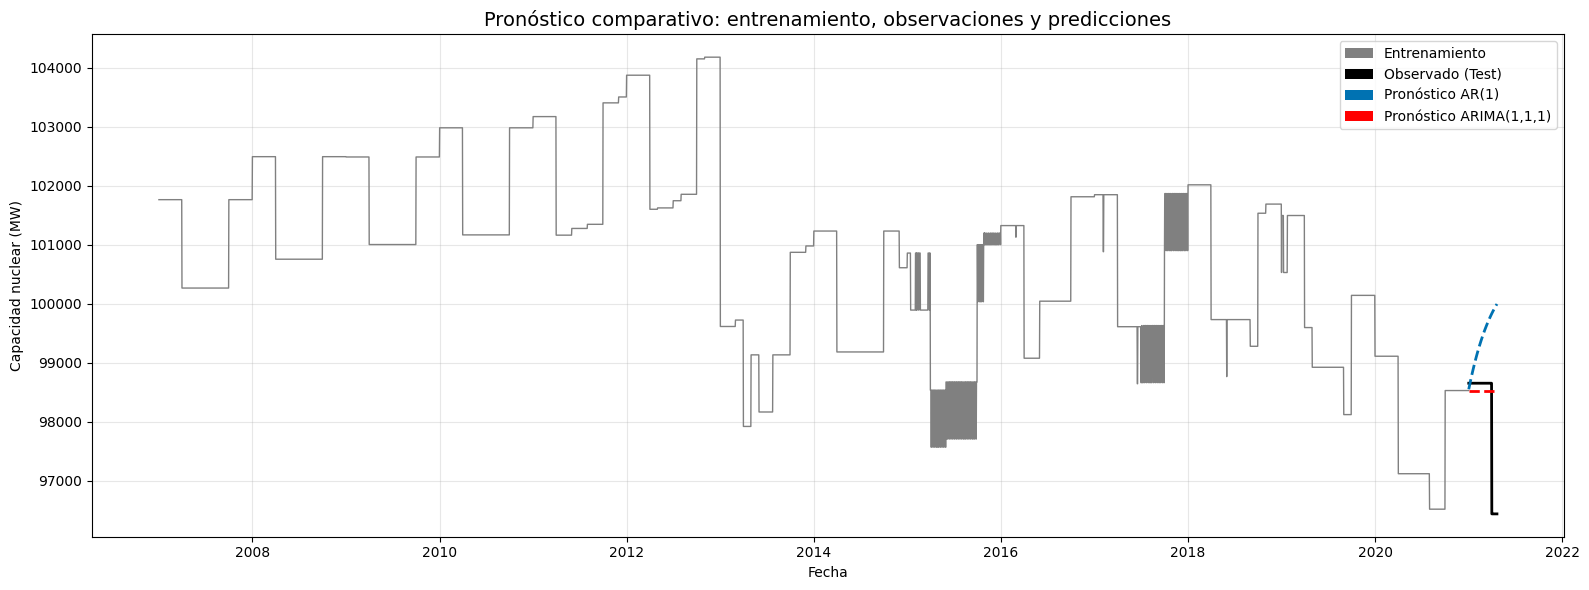

In [32]:
colors = {
    'AR(1)': '#0072B2',        # Azul oscuro
    'ARIMA(1,1,1)': '#FF0000'  # Rojo
}

plt.figure(figsize=(16, 6))

# Datos observados
plt.plot(train.index, train, label="Entrenamiento", color='gray', linewidth=1)
plt.plot(test.index, test, label="Observado (Test)", color='black', linewidth=2)

# Predicción AR(1)
plt.plot(test.index, pred_ar1, label="Pronóstico AR(1)", color=colors['AR(1)'], linestyle='--', linewidth=2)

# Predicción ARIMA(1,1,1)
plt.plot(test.index, pred_111, label="Pronóstico ARIMA(1,1,1)", color=colors['ARIMA(1,1,1)'], linestyle='--', linewidth=2)

plt.title("Pronóstico comparativo: entrenamiento, observaciones y predicciones", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Capacidad nuclear (MW)")

# Crear leyenda personalizada
legend_elements = [
    # Datos observados
    mpatches.Patch(facecolor='gray', label='Entrenamiento'),
    mpatches.Patch(facecolor='black', label='Observado (Test)'),
    
    # Modelos
    mpatches.Patch(facecolor=colors['AR(1)'], label='Pronóstico AR(1)'),
    mpatches.Patch(facecolor=colors['ARIMA(1,1,1)'], label='Pronóstico ARIMA(1,1,1)'),
]

# Agregar leyenda personalizada
plt.legend(handles=legend_elements, loc='best')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparacion_ar1_arima.png', dpi=300, bbox_inches='tight')
plt.show()

#### 2. SARIMA

Se decidió probar un modelo SARIMA (ARIMA estacional), que permite capturar posibles patrones repetitivos en la serie, como fluctuaciones semanales o mensuales. Esto es especialmente relevante en series diarias como la capacidad nuclear, donde pueden existir ciclos operativos o estacionales que un modelo no estacional no podría detectar ni aprovechar.

Se seleccionaron estacionalidades de 7 días (s=7) para representar un ciclo semanal típico —por ejemplo, diferencias entre fines de semana y días hábiles—, y de 30 días (s=30) para capturar posibles variaciones mensuales vinculadas a mantenimiento, planificación o consumo energético.

In [33]:
# Entrenar SARIMA con estacionalidad semanal (s=7)
modelo_sarimax_7 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,7))
res_sarimax_7, pred_sarimax_7 = evaluar_modelo_con_significancia(modelo_sarimax_7, train, test, nombre="SARIMAX(1,1,1)(1,0,1,7)")
pred_sarimax_7 = res_sarimax_7.forecast(steps=len(test))
ajuste_sarimax_7 = res_sarimax_7.fittedvalues.iloc[1:]
ajuste_sarimax_7.index = train.index[1:]

# Entrenar SARIMA con estacionalidad mensual (s=30)
modelo_sarimax_30 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,30))
res_sarimax_30, pred_sarimax_30 = evaluar_modelo_con_significancia(modelo_sarimax_30, train, test, nombre="SARIMAX(1,1,1)(1,0,1,30)")
pred_sarimax_30 = res_sarimax_30.forecast(steps=len(test))
ajuste_sarimax_30 = res_sarimax_30.fittedvalues.iloc[1:]
ajuste_sarimax_30.index = train.index[1:]

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📘 SARIMAX(1,1,1)(1,0,1,7) → AIC: 69006.04 | RMSE: 1031.98
Resumen de coeficientes:
                                     SARIMAX Results                                     
Dep. Variable:                         Capacidad   No. Observations:                 5114
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -34498.022
Date:                           Wed, 23 Apr 2025   AIC                          69006.045
Time:                                   23:44:13   BIC                          69038.742
Sample:                               01-01-2007   HQIC                         69017.492
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9666      0.005    19

/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jorge/miniconda3/envs/ast-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📘 SARIMAX(1,1,1)(1,0,1,30) → AIC: 69933.03 | RMSE: 908.10
Resumen de coeficientes:
                                     SARIMAX Results                                      
Dep. Variable:                          Capacidad   No. Observations:                 5114
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 30)   Log Likelihood              -34961.513
Date:                            Wed, 23 Apr 2025   AIC                          69933.026
Time:                                    23:44:20   BIC                          69965.723
Sample:                                01-01-2007   HQIC                         69944.473
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6548      0.0

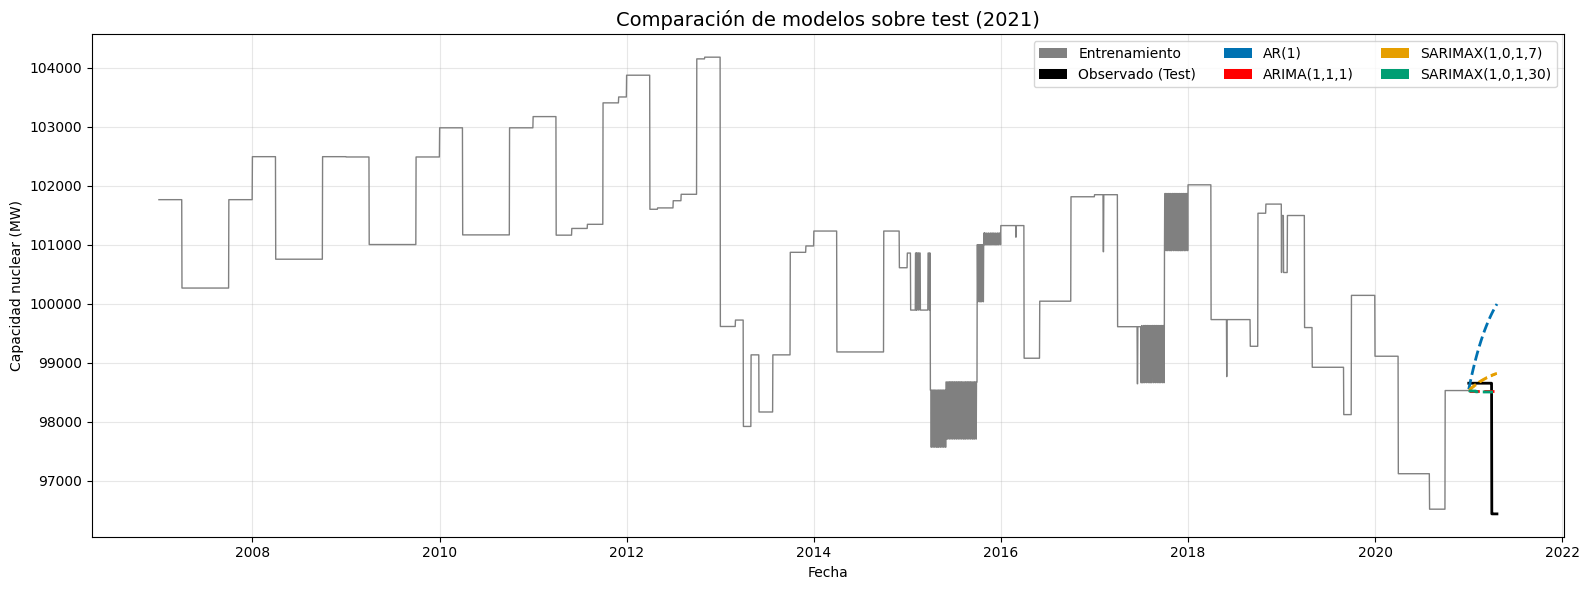

In [34]:
colors = {
    'AR(1)': '#0072B2',             # Azul oscuro
    'ARIMA(1,1,1)': '#FF0000',      # Rojo
    'SARIMAX(1,0,1,7)': '#E69F00',  # Amarillo-ámbar
    'SARIMAX(1,0,1,30)': '#009E73', # Verde oscuro
}

plt.figure(figsize=(16, 6))

# Datos observados
plt.plot(train.index, train, label="Entrenamiento", color='gray', linewidth=1)
plt.plot(test.index, test, label="Observado (Test)", color='black', linewidth=2)

# Predicciones con colores consistentes
plt.plot(test.index, pred_ar1, label="AR(1)", color=colors['AR(1)'], linestyle='--', linewidth=2)
plt.plot(test.index, pred_111, label="ARIMA(1,1,1)", color=colors['ARIMA(1,1,1)'], linestyle='--', linewidth=2)
plt.plot(test.index, pred_sarimax_7, label="SARIMAX(1,0,1,7)", color=colors['SARIMAX(1,0,1,7)'], linestyle='--', linewidth=2)
plt.plot(test.index, pred_sarimax_30, label="SARIMAX(1,0,1,30)", color=colors['SARIMAX(1,0,1,30)'], linestyle='--', linewidth=2)

plt.title("Comparación de modelos sobre test (2021)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Capacidad nuclear (MW)")

# Crear leyenda personalizada con patches
legend_elements = [
    # Datos observados
    mpatches.Patch(facecolor='gray', label='Entrenamiento'),
    mpatches.Patch(facecolor='black', label='Observado (Test)'),
    
    # Modelos
    mpatches.Patch(facecolor=colors['AR(1)'], label='AR(1)'),
    mpatches.Patch(facecolor=colors['ARIMA(1,1,1)'], label='ARIMA(1,1,1)'),
    mpatches.Patch(facecolor=colors['SARIMAX(1,0,1,7)'], label='SARIMAX(1,0,1,7)'),
    mpatches.Patch(facecolor=colors['SARIMAX(1,0,1,30)'], label='SARIMAX(1,0,1,30)'),
]

# Agregar leyenda con la configuración personalizada
plt.legend(handles=legend_elements, loc='best', ncol=3)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparacion_modelos_test.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3. PROPHET

Se eligió incluir Prophet como modelo alternativo debido a su capacidad para detectar tendencias y estacionalidades de forma automática, sin necesidad de definir manualmente los parámetros como en ARIMA o SARIMA. Prophet fue desarrollado por Facebook para ser fácil de usar, interpretable y robusto a outliers o datos faltantes, lo que lo convierte en una excelente opción cuando se trabaja con series temporales complejas.

In [58]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Usar solo el conjunto de entrenamiento para entrenar el modelo
df_prophet = df_clean.reset_index()[['fecha', 'Capacidad']].rename(columns={'fecha': 'ds', 'Capacidad': 'y'})
df_prophet_train = df_prophet[df_prophet['ds'] <= '2020-12-31']

# Entrenar el modelo solo con datos hasta 2020
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(df_prophet_train)

# Crear marco de predicción para todo el periodo (hasta fin de test)
future = modelo_prophet.make_future_dataframe(periods=len(test))
forecast = modelo_prophet.predict(future)

# Separar pronóstico para el test
forecast_test = forecast[forecast['ds'] >= '2021-01-01']

# Alinear y calcular métricas
y_pred_prophet = forecast_test.set_index('ds').loc[test.index]['yhat']
y_true_prophet = test

rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)

print(f"RMSE Prophet: {rmse_prophet:.2f}")
print(f"MAE  Prophet: {mae_prophet:.2f}")

17:02:25 - cmdstanpy - INFO - Chain [1] start processing
17:02:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE Prophet: 669.82
MAE  Prophet: 623.84


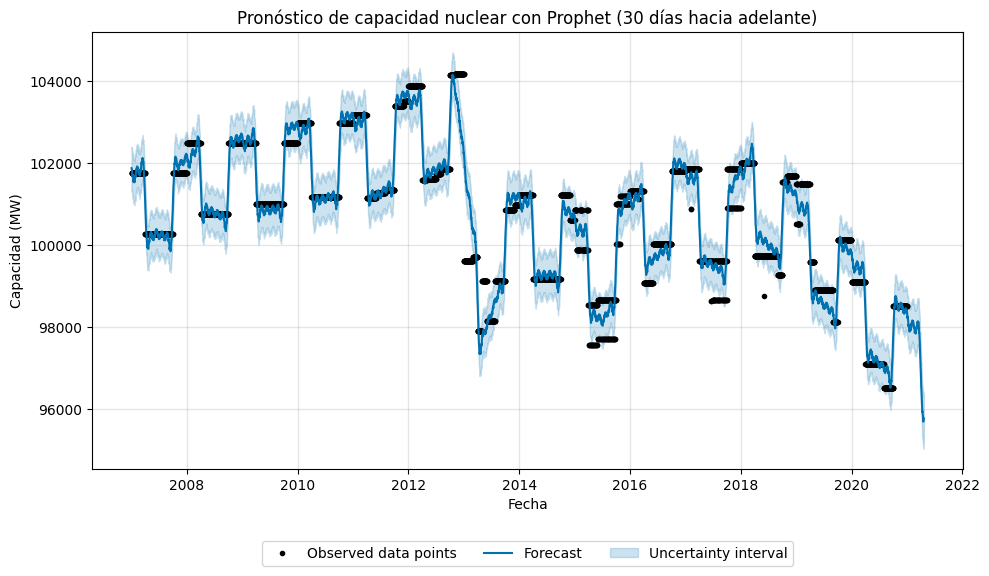

In [64]:
fig = modelo_prophet.plot(forecast)
ax = fig.gca()

ax.set_title("Pronóstico de capacidad nuclear con Prophet (30 días hacia adelante)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Capacidad (MW)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)
ax.grid(True)
plt.tight_layout()
plt.show()

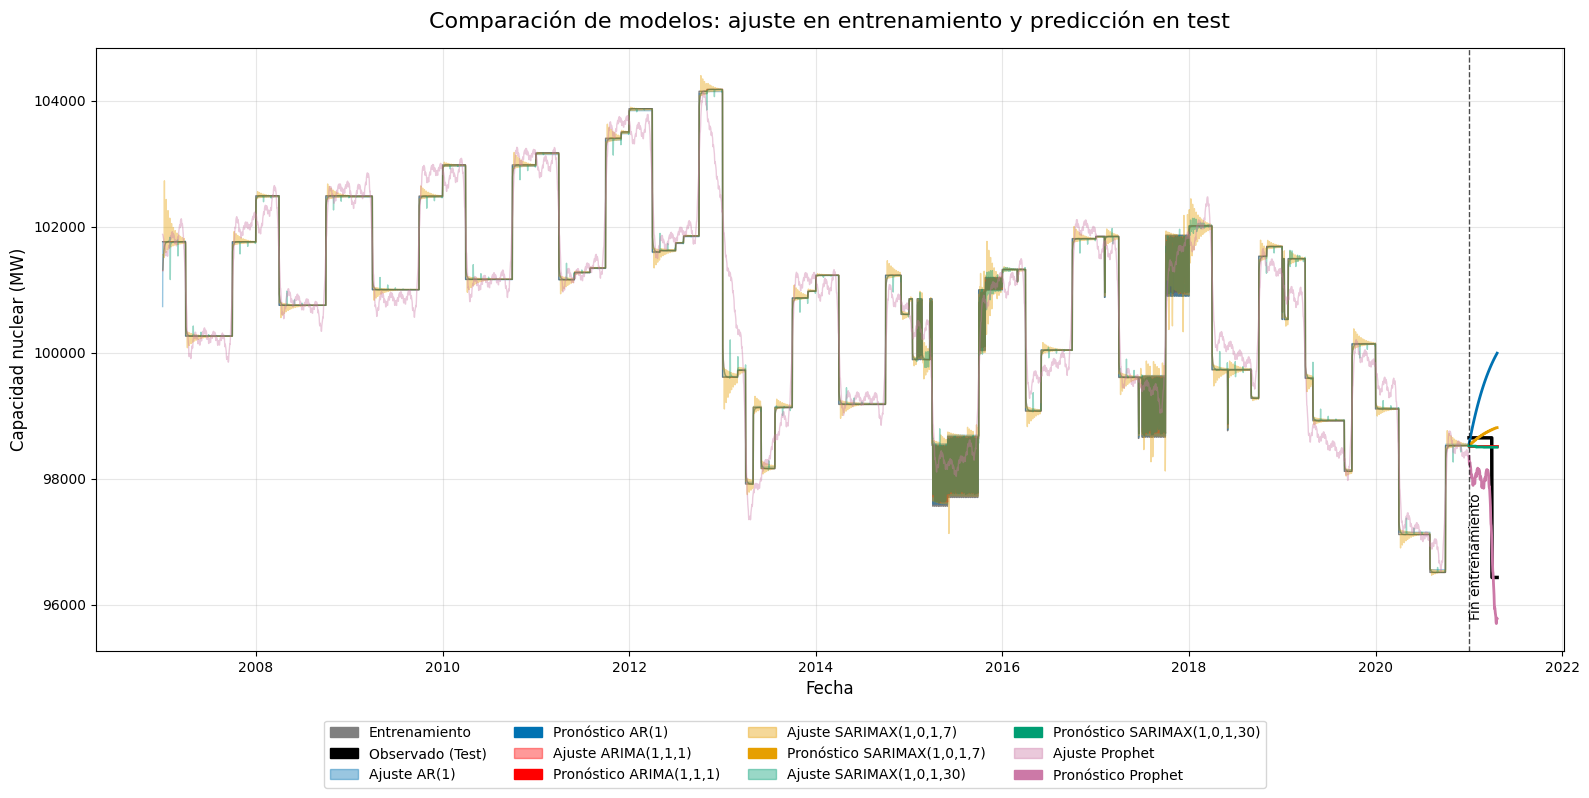

In [65]:
plt.figure(figsize=(16, 8))  # Ajustado la altura ya que solo tendremos un panel

# Panel único para datos completos (entrenamiento y test)
ax = plt.subplot(1, 1, 1)  # Un solo panel que ocupa todo el espacio

# Datos observados
ax.plot(train.index, train, label="Entrenamiento", color='gray', linewidth=1)
ax.plot(test.index, test, label="Observado (Test)", color='black', linewidth=2.5)

# Colores más distinguibles y mejoras en la visualización
colors = {
    'AR(1)': '#0072B2',             # Azul oscuro
    'ARIMA(1,1,1)': '#FF0000',      # Rojo
    'SARIMAX(1,0,1,7)': '#E69F00',  # Amarillo-ámbar
    'SARIMAX(1,0,1,30)': '#009E73', # Verde oscuro
    'Prophet': '#CC79A7'            # Rosa
}

# Ajuste de cada modelo
# Datos de ajuste con transparencia y líneas más delgadas
# AR(1)
ax.plot(ajuste_ar1.index, ajuste_ar1, label="Ajuste AR(1)", 
        color=colors['AR(1)'], alpha=0.4, linewidth=1)
# ARIMA(1,1,1)
ax.plot(ajuste_111.index, ajuste_111, label="Ajuste ARIMA(1,1,1)", 
        color=colors['ARIMA(1,1,1)'], alpha=0.4, linewidth=1)
# SARIMAX (1,0,1,7)
ax.plot(ajuste_sarimax_7.index, ajuste_sarimax_7, label="Ajuste SARIMAX(1,0,1,7)", 
        color=colors['SARIMAX(1,0,1,7)'], alpha=0.4, linewidth=1)
# SARIMAX (1,0,1,30)
ax.plot(ajuste_sarimax_30.index, ajuste_sarimax_30, label="Ajuste SARIMAX(1,0,1,30)", 
        color=colors['SARIMAX(1,0,1,30)'], alpha=0.4, linewidth=1)
# Prophet
ax.plot(forecast['ds'], forecast['yhat'], label="Ajuste Prophet", 
        color=colors['Prophet'], alpha=0.4, linewidth=1)

# Pronóstico de cada modelo
# Destacar las predicciones con líneas más gruesas y estilos más distinguibles
# AR(1)
ax.plot(test.index, pred_ar1, label="Pronóstico AR(1)", 
        color=colors['AR(1)'], linestyle='-', linewidth=2)
# ARIMA(1,1,1)
ax.plot(test.index, pred_111, label="Pronóstico ARIMA(1,1,1)", 
        color=colors['ARIMA(1,1,1)'], linestyle='-', linewidth=2)
# SARIMAX (1,0,1,7)
ax.plot(test.index, pred_sarimax_7, label="Pronóstico SARIMAX(1,0,1,7)", 
        color=colors['SARIMAX(1,0,1,7)'], linestyle='-', linewidth=2)
# SARIMAX (1,0,1,30)
ax.plot(test.index, pred_sarimax_30, label="Pronóstico SARIMAX(1,0,1,30)", 
        color=colors['SARIMAX(1,0,1,30)'], linestyle='-', linewidth=2)
# Prophet
ax.plot(forecast_test['ds'], forecast_test['yhat'], label="Pronóstico Prophet", 
        color=colors['Prophet'], linestyle='-', linewidth=2)

# Mejoras estéticas
ax.set_title("Comparación de modelos: ajuste en entrenamiento y predicción en test", fontsize=16, pad=15)
ax.set_ylabel("Capacidad nuclear (MW)", fontsize=12)
ax.set_xlabel("Fecha", fontsize=12)  # Añadido ya que ahora es el único panel
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=10)

# Marcar visualmente la separación entre entrenamiento y test
max_train_date = train.index[-1]
min_test_date = test.index[0]
ax.axvline(x=max_train_date, color='black', linestyle='--', alpha=0.7, linewidth=1)
ax.text(max_train_date, ax.get_ylim()[0] + 500, 'Fin entrenamiento', 
        rotation=90, verticalalignment='bottom')

# Crear leyenda personalizada para cada modelo con mejor organización
# Agrupando ajuste y pronóstico por modelo
handles = []
labels = []

# Datos observados
train_patch = mpatches.Patch(color='gray', label='Entrenamiento')
test_patch = mpatches.Patch(color='black', label='Observado (Test)')
handles.extend([train_patch, test_patch])
labels.extend(['Entrenamiento', 'Observado (Test)'])

# Para cada modelo, crear par de líneas: ajuste y pronóstico
models = ['AR(1)', 'ARIMA(1,1,1)', 'SARIMAX(1,0,1,7)', 'SARIMAX(1,0,1,30)', 'Prophet']
for model in models:
    # Línea de ajuste
    ajuste = mpatches.Patch(color=colors[model], alpha=0.4, label=f'Ajuste {model}')
    # Línea de pronóstico
    pronostico = mpatches.Patch(color=colors[model], label=f'Pronóstico {model}')
    
    handles.extend([ajuste, pronostico])
    labels.extend([f'Ajuste {model}', f'Pronóstico {model}'])

# Colocar leyenda debajo del gráfico con varias columnas
plt.figlegend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0), 
              frameon=True, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)  # Ajustar espacio para la leyenda
plt.savefig('comparacion_modelos_mejorada_prophet.png', dpi=300, bbox_inches='tight')
plt.show()

### Modelo de deep learning

#### 1. LSTM

Para incorporar un enfoque basado en aprendizaje profundo, se decidió probar una red neuronal del tipo LSTM (Long Short-Term Memory), especializada en modelar secuencias temporales con dependencias de largo plazo. Se utilizó una estructura sencilla con una sola capa LSTM de 50 unidades, seguida por una capa densa de salida. El modelo fue entrenado utilizando una ventana deslizante de 30 días como entrada (lookback) para predecir el valor del día siguiente, sobre datos previamente escalados.

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Escalar train y test por separado
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Parámetro de ventana
lookback = 30

# --- CREAR VENTANAS PARA TRAIN ---
X_train, y_train = [], []
for i in range(lookback, len(train_scaled)):
    X_train.append(train_scaled[i - lookback:i, 0])
    y_train.append(train_scaled[i, 0])
X_train = np.array(X_train).reshape(-1, lookback, 1)
y_train = np.array(y_train)

# --- CREAR VENTANAS PARA TEST ---
X_test, y_test = [], []
test_input = np.concatenate([train_scaled[-lookback:], test_scaled])
for i in range(lookback, len(test_input)):
    X_test.append(test_input[i - lookback:i, 0])
    y_test.append(test_input[i, 0])
X_test = np.array(X_test).reshape(-1, lookback, 1)
y_test = np.array(y_test)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predicción sobre test
pred_lstm_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluación
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, pred_lstm))
mae_lstm = mean_absolute_error(y_test_actual, pred_lstm)

print(f"RMSE LSTM: {rmse_lstm:.2f}")
print(f"MAE  LSTM: {mae_lstm:.2f}")

# Ajuste sobre entrenamiento
pred_lstm_train_scaled = model.predict(X_train)
pred_lstm_train = scaler.inverse_transform(pred_lstm_train_scaled)

# Crear Series para graficar
ajuste_lstm_index = train.index[lookback:]  # salteo los primeros 30 días no predichos
ajuste_lstm = pd.Series(pred_lstm_train.flatten(), index=ajuste_lstm_index)

# Crear Series para predicción sobre test
pred_lstm_series = pd.Series(pred_lstm.flatten(), index=test.index[-len(pred_lstm):])


Epoch 1/20


/home/tmonreal/Desktop/Time_Series_Analysis/tpfinal_ast/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0980
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0021
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0018
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0016
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0013
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0015
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0014
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 9/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0013
Epoch 10/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 11/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0011
Epoch 12/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 13/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.3112e-04
Epoch 14/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.5846e-04
Epoch 15/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15

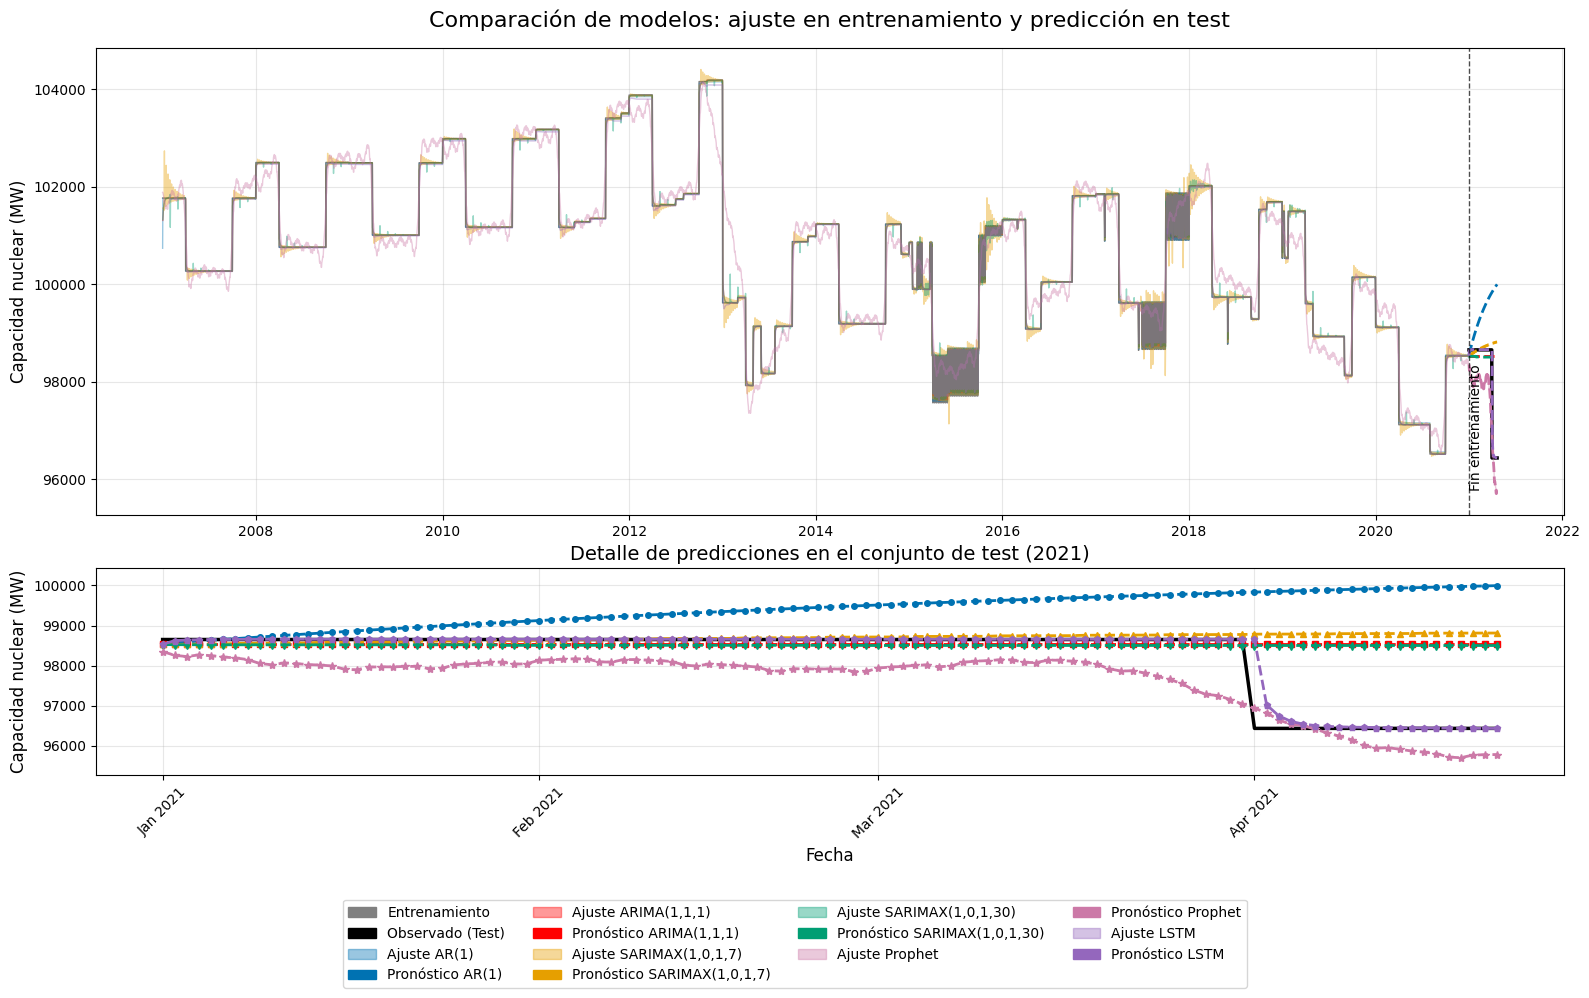

In [66]:
plt.figure(figsize=(16, 10))

# 1. Panel principal para datos de entrenamiento (Se mantiene igual)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

# Datos observados
ax1.plot(train.index, train, label="Entrenamiento", color='gray', linewidth=1)
ax1.plot(test.index, test, label="Observado (Test)", color='black', linewidth=2.5)

# Colores más distinguibles y mejoras en la visualización
colors = {
    'AR(1)': '#0072B2',             # Azul oscuro
    'ARIMA(1,1,1)': '#FF0000',      # Rojo
    'SARIMAX(1,0,1,7)': '#E69F00',  # Amarillo-ámbar
    'SARIMAX(1,0,1,30)': '#009E73', # Verde oscuro
    'Prophet': '#CC79A7',           # Rosa
    'LSTM': '#9467BD'               # Púrpura
}

# Ajuste de cada modelo
# Datos de ajuste con transparencia y líneas más delgadas
# AR(1)
ax1.plot(ajuste_ar1.index, ajuste_ar1, label="Ajuste AR(1)", 
         color=colors['AR(1)'], alpha=0.4, linewidth=1)
# ARIMA(1,1,1)
ax1.plot(ajuste_111.index, ajuste_111, label="Ajuste ARIMA(1,1,1)", 
         color=colors['ARIMA(1,1,1)'], alpha=0.4, linewidth=1)
# SARIMAX (1,0,1,7)
ax1.plot(ajuste_sarimax_7.index, ajuste_sarimax_7, label="Ajuste SARIMAX(1,0,1,7)", 
         color=colors['SARIMAX(1,0,1,7)'], alpha=0.4, linewidth=1)
# SARIMAX (1,0,1,30)
ax1.plot(ajuste_sarimax_30.index, ajuste_sarimax_30, label="Ajuste SARIMAX(1,0,1,30)", 
         color=colors['SARIMAX(1,0,1,30)'], alpha=0.4, linewidth=1)
# Prophet
ax1.plot(forecast['ds'], forecast['yhat'], label="Ajuste Prophet", 
         color=colors['Prophet'], alpha=0.4, linewidth=1)
ax1.plot(ajuste_lstm.index, ajuste_lstm, label="Ajuste LSTM", 
         color=colors['LSTM'], alpha=0.4, linewidth=1)

# Pronóstico de cada modelo
# Destacar las predicciones con líneas más gruesas y estilos más distinguibles
# AR(1)
ax1.plot(test.index, pred_ar1, label="Pronóstico AR(1)", 
         color=colors['AR(1)'], linestyle='--', linewidth=2)
# ARIMA(1,1,1)
ax1.plot(test.index, pred_111, label="Pronóstico ARIMA(1,1,1)", 
         color=colors['ARIMA(1,1,1)'], linestyle='--', linewidth=2)
# SARIMAX (1,0,1,7)
ax1.plot(test.index, pred_sarimax_7, label="Pronóstico SARIMAX(1,0,1,7)", 
         color=colors['SARIMAX(1,0,1,7)'], linestyle='--', linewidth=2)
# SARIMAX (1,0,1,30)
ax1.plot(test.index, pred_sarimax_30, label="Pronóstico SARIMAX(1,0,1,30)", 
         color=colors['SARIMAX(1,0,1,30)'], linestyle='--', linewidth=2)
# Prophet
ax1.plot(forecast_test['ds'], forecast_test['yhat'], label="Pronóstico Prophet", 
         color=colors['Prophet'], linestyle='--', linewidth=2)
# LSTM
ax1.plot(pred_lstm_series.index, pred_lstm_series, label="Pronóstico LSTM", 
         color=colors['LSTM'], linestyle='--', linewidth=2)

# Mejoras estéticas
ax1.set_title("Comparación de modelos: ajuste en entrenamiento y predicción en test", fontsize=16, pad=15)
ax1.set_ylabel("Capacidad nuclear (MW)", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Marcar visualmente la separación entre entrenamiento y test
max_train_date = train.index[-1]
min_test_date = test.index[0]
ax1.axvline(x=max_train_date, color='black', linestyle='--', alpha=0.7, linewidth=1)
ax1.text(max_train_date, ax1.get_ylim()[0] + 500, 'Fin entrenamiento', 
         rotation=90, verticalalignment='bottom')

# 2. Panel inferior modificado: Zoom en predicciones para el conjunto de test (2021)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

# Datos observados en el conjunto de test
ax2.plot(test.index, test, label="Observado (Test)", color='black', linewidth=2.5)

# Predicciones de cada modelo 
# AR(1)
ax2.plot(test.index, pred_ar1, label="Pronóstico AR(1)", 
         color=colors['AR(1)'], linestyle='--', linewidth=2, marker='o', markersize=4)
# ARIMA(1,1,1)
ax2.plot(test.index, pred_111, label="Pronóstico ARIMA(1,1,1)", 
         color=colors['ARIMA(1,1,1)'], linestyle='--', linewidth=2, marker='s', markersize=4)
# SARIMAX (1,0,1,7)
ax2.plot(test.index, pred_sarimax_7, label="Pronóstico SARIMAX(1,0,1,7)", 
         color=colors['SARIMAX(1,0,1,7)'], linestyle='--', linewidth=2, marker='^', markersize=4)
# SARIMAX (1,0,1,30)
ax2.plot(test.index, pred_sarimax_30, label="Pronóstico SARIMAX(1,0,1,30)", 
         color=colors['SARIMAX(1,0,1,30)'], linestyle='--', linewidth=2, marker='d', markersize=4)
# Prophet
ax2.plot(forecast_test['ds'], forecast_test['yhat'], label="Pronóstico Prophet", 
         color=colors['Prophet'], linestyle='--', linewidth=2, marker='*', markersize=6)
# LSTM
ax2.plot(pred_lstm_series.index, pred_lstm_series, label="Pronóstico LSTM", 
         color=colors['LSTM'], linestyle='--', linewidth=2, marker='p', markersize=5)

# Formato del eje X para fechas
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Mejoras estéticas para el panel inferior
ax2.set_title("Detalle de predicciones en el conjunto de test (2021)", fontsize=14)
ax2.set_ylabel("Capacidad nuclear (MW)", fontsize=12)
ax2.set_xlabel("Fecha", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Ajustar el eje Y para tener un buen zoom en las predicciones
buffer = (max(test.max(), pred_ar1.max(), pred_111.max(), pred_sarimax_7.max(), 
             pred_sarimax_30.max(), forecast_test['yhat'].max(), pred_lstm_series.max()) - 
           min(test.min(), pred_ar1.min(), pred_111.min(), pred_sarimax_7.min(), 
              pred_sarimax_30.min(), forecast_test['yhat'].min(), pred_lstm_series.min())) * 0.1
ymin = min(test.min(), pred_ar1.min(), pred_111.min(), pred_sarimax_7.min(), 
          pred_sarimax_30.min(), forecast_test['yhat'].min(), pred_lstm_series.min()) - buffer
ymax = max(test.max(), pred_ar1.max(), pred_111.max(), pred_sarimax_7.max(), 
          pred_sarimax_30.max(), forecast_test['yhat'].max(), pred_lstm_series.max()) + buffer
ax2.set_ylim(ymin, ymax)

# Crear leyenda personalizada para cada modelo con mejor organización
# Agrupando ajuste y pronóstico por modelo
handles = []
labels = []

# Datos observados
train_patch = mpatches.Patch(color='gray', label='Entrenamiento')
test_patch = mpatches.Patch(color='black', label='Observado (Test)')
handles.extend([train_patch, test_patch])
labels.extend(['Entrenamiento', 'Observado (Test)'])

# Para cada modelo, crear par de líneas: ajuste y pronóstico
models = ['AR(1)', 'ARIMA(1,1,1)', 'SARIMAX(1,0,1,7)', 'SARIMAX(1,0,1,30)', 'Prophet', 'LSTM']
for model in models:
    # Línea de ajuste
    ajuste = mpatches.Patch(color=colors[model], alpha=0.4, label=f'Ajuste {model}')
    # Línea de pronóstico
    pronostico = mpatches.Patch(color=colors[model], label=f'Pronóstico {model}')
    
    handles.extend([ajuste, pronostico])
    labels.extend([f'Ajuste {model}', f'Pronóstico {model}'])

# Colocar leyenda debajo del gráfico con varias columnas
plt.figlegend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0), 
              frameon=True, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)  # Ajustar espacio para la leyenda
plt.savefig('comparacion_modelos_mejorada_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

### Resultados

<table style="border-collapse: collapse; width: 100%;">
  <thead>
    <tr style="background-color: rgb(100, 104, 195);">
      <th style="border: 1px solid #ddd; padding: 8px;">Modelo</th>
      <th style="border: 1px solid #ddd; padding: 8px;">AIC</th>
      <th style="border: 1px solid #ddd; padding: 8px;">BIC</th>
      <th style="border: 1px solid #ddd; padding: 8px;">Log Likelihood</th>
      <th style="border: 1px solid #ddd; padding: 8px;">RMSE</th>
      <th style="border: 1px solid #ddd; padding: 8px;">MAE</th>
      <th style="border: 1px solid #ddd; padding: 8px;">Prob(Q)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">AR(1)</td>
      <td style="border: 1px solid #ddd; padding: 8px;">70122.30</td>
      <td style="border: 1px solid #ddd; padding: 8px;">70141.92</td>
      <td style="border: 1px solid #ddd; padding: 8px;">-35058.15</td>
      <td style="border: 1px solid #ddd; padding: 8px;">1650.33</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">0.71</td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">ARIMA(1,1,1)</td>
      <td style="border: 1px solid #ddd; padding: 8px;">70028.18</td>
      <td style="border: 1px solid #ddd; padding: 8px;">70047.80</td>
      <td style="border: 1px solid #ddd; padding: 8px;">-35011.09</td>
      <td style="border: 1px solid #ddd; padding: 8px;">916.87</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">0.00</td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">SARIMAX(1,1,1)(1,0,1,7)</td>
      <td style="border: 1px solid #ddd; padding: 8px;">69006.04</td>
      <td style="border: 1px solid #ddd; padding: 8px;">69038.74</td>
      <td style="border: 1px solid #ddd; padding: 8px;">-34498.02</td>
      <td style="border: 1px solid #ddd; padding: 8px;">1030.69</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">0.00</td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">SARIMAX(1,1,1)(1,0,1,30)</td>
      <td style="border: 1px solid #ddd; padding: 8px;">69933.03</td>
      <td style="border: 1px solid #ddd; padding: 8px;">69965.72</td>
      <td style="border: 1px solid #ddd; padding: 8px;">-34961.51</td>
      <td style="border: 1px solid #ddd; padding: 8px;">908.10</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">0.00</td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">Prophet</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">549.38</td>
      <td style="border: 1px solid #ddd; padding: 8px;">498.57</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;">LSTM</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
      <td style="border: 1px solid #ddd; padding: 8px;">236.02</td>
      <td style="border: 1px solid #ddd; padding: 8px;">44.16</td>
      <td style="border: 1px solid #ddd; padding: 8px;">—</td>
    </tr>
  </tbody>
</table>


Modelos Clásicos: ARIMA / SARIMAX

- **SARIMAX(1,1,1)(1,0,1,7)** tuvo el mejor desempeño entre los modelos estadísticos: tuvo el AIC más bajo (69006.04), un RMSE competitivo (1030.69). Además, tuvo coeficientes altamente significativos. Consideramos que este modelo es capaz de capturar una estacionalidad semanal clara, lo cual es coherente con series diarias.

- **SARIMAX(1,1,1)(1,0,1,30)** mostró también buen rendimiento (RMSE:908.10), aunque con mayor AIC. Esto nos puede sugerir una estacionalidad mensual, pero menos fuerte que la semanal.

- **ARIMA(1,1,1)** superó a AR(1) en RMSE, pero sin capturar estacionalidad. Es un modelo base sólido si se busca simplicidad sin incorporar estacionalidad explícita.

- **AR(1)** mostró el peor desempeño (RMSE: 1650.33, AIC: 70122.30). No es adecuado para esta serie, al no capturar su complejidad.

Modelos Modernos: Prophet y LSTM

- **Prophet**: obtuvo un muy buen RMSE (549.38) y MAE (498.57). Es ideal para modelado rápido con mínimo tuning manual, capturando estacionalidades y tendencias automáticamente. Lo negativo sería que no permite análisis estadístico tradicional (sin AIC/BIC) para comparar con los modelos previos.

- **LSTM**: obtuvo la mejor precisión en test: RMSE de 236.02 y MAE de 44.16. Permite captura patrones complejos y no lineales. Si bien equiere mayor capacidad de cómputo, con esta serie de tiempo se pudo usar un modelo bastante simple que corre rápido. Algo negativo es que al ser un modelo de deep learning, es una caja negra no interpretable. En nuestro caso es útil, ya que el objetivo es únicamente la **predicción precisa**.